# Segunda entrega

En esta segunda entrega vamos a hacer un análisis de reviews en Yelp.

Dado el siguiente dataset https://drive.google.com/file/d/1sVeJE4zd1fmLnOgYI5QlQeaeaTGa8kIE/view?usp=sharing:

In [64]:
#para descargarlo desde colab
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1sVeJE4zd1fmLnOgYI5QlQeaeaTGa8kIE' -O reviews.csv

In [96]:
# !pip install -U spacy
# !python -m spacy download en_core_web_sm
# !pip install matplotlib --upgrade
# !pip install keybert
# !pip install bertopic

In [39]:
# Los de siempre
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Para NLP
import spacy
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from wordcloud import WordCloud
from textblob import TextBlob
import tensorflow as tf
from keybert import KeyBERT
from bertopic import BERTopic

# models
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, plot_confusion_matrix

# classifiers
from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import  classification_report, confusion_matrix, ConfusionMatrixDisplay

La siguiente celda, sirve para que cuando imprimamos un dataframe, pandas nos muestre el texto entero y no lo corte con "..."

In [6]:
pd.options.display.max_colwidth = 10000

Importamos el archivo a procesar

In [5]:
df = pd.read_csv('https://docs.google.com/uc?export=download&id=1sVeJE4zd1fmLnOgYI5QlQeaeaTGa8kIE')
# df = pd.read_csv('CSV/reviews.csv')
df.head()

user_id               review_id  \
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
1  Iu6AxdBYGR4A0wspR9BYHA  KPvLNJ21_4wbYNctrOwWdQ   
2  auESFwWvW42h6alXgFxAXQ  fFSoGV46Yxuwbr3fHNuZig   
3  uK8tzraOp4M5u3uYrqIBXg  Di3exaUCFNw1V4kSNW5pgA   
4  I_47G-R2_egp7ME5u_ltew  0Lua2-PbqEQMjD9r89-asw   

                                                text  votes.cool  \
0  Mr Hoagie is an institution. Walking in, it do...           0   
1  Excellent food. Superb customer service. I mis...           0   
2  Yes this place is a little out dated and not o...           0   
3  All the food is great here. But the best thing...           0   
4  We checked this place out this past Monday for...           0   

              business_id  votes.funny  stars        date    type  \
0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
1  5UmKMjUEUNdYWqANhGckJw            0      5  2014-02-13  review   
2  5UmKMjUEUNdYWqANhGckJw            0      5  2015-10-31  review   
3  UsFtqoBl7naz8AVUBZMjQQ            0      5  2013-11-08  review   
4  UsFtqoBl7naz8AVUBZMjQQ            0      3  2014-03-29  review   

   votes.useful  
0             0  
1             0  
2             0  
3             0  
4             0

Deberán hacer un análisis de las reviews.

El análisis no tiene limites y pueden agregar todas las ideas que les surjan, pero como mínimo debe incluir: keywords y tópicos por negocio (business id), sentimiento de cada review, entidades por review, negocio con más comentarios positivos y negocio con más comentarios negativos.

Además, pueden agregar por ejemplo (Opcional): Tópicos asociados sentimientos, keywords asociadas a sentimientos, sentimientos a lo largo del tiempo (utilizando la columna date)...

### Entrega

**Fecha limite**: 26 de Diciembre. 

Deben compartir el notebook con todo el análisis realizado por mail a alexispacek@gmail.com.


### Presentación

**Fecha**: 28 de Diciembre.

La presentación NO debe ser una presentación del notebook. La presentación debe constar de filminas que muestren los **resultados** que obtuvieron, mencionar herramientas que utiliaron, que decisiones tomaron y conclusiones. No deben mostrar nada de código en la presentación.

Una vez que ya hayan presentado (por ejemplo un powerpoint), podemos resolver las dudas que surjan sobre código, etc.



# Exploratory Data Analysis (EDA)

Empezamos a conocer: cantidad de filas y columnas, tipos de variables, valores nulos, etc.

In [ ]:
df.shape

(27290, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27290 entries, 0 to 27289
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       27290 non-null  object
 1   review_id     27290 non-null  object
 2   text          27290 non-null  object
 3   votes.cool    27290 non-null  int64 
 4   business_id   27290 non-null  object
 5   votes.funny   27290 non-null  int64 
 6   stars         27290 non-null  int64 
 7   date          27290 non-null  object
 8   type          27290 non-null  object
 9   votes.useful  27290 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 2.1+ MB


In [ ]:
# Cantidad de nulos
df.isna().sum()

user_id         0
review_id       0
text            0
votes.cool      0
business_id     0
votes.funny     0
stars           0
date            0
type            0
votes.useful    0
dtype: int64

In [4]:
# Eliminamos duplicados
print(len(df))
df = df.drop_duplicates(subset='text', keep='first')
print(len(df))

27290
27269


In [ ]:
df['stars'].nunique()

5

In [4]:
df['votes.cool'].nunique()

26

In [ ]:
df['votes.funny'].nunique()

27

In [ ]:
df['votes.useful'].nunique()

28

In [10]:
# Vemos que el feature 'type' tiene un solo valor, lo eliminamos del dataset.
print(df['type'].nunique())
df = df.drop('type', axis=1)

1


In [5]:
# Cantidad de reviews
df['review_id'].nunique()

27269

In [ ]:
# Cantidad de usuarios
df['user_id'].nunique()

14861

In [4]:
# Cantidad de negocios
df['business_id'].nunique()

1320

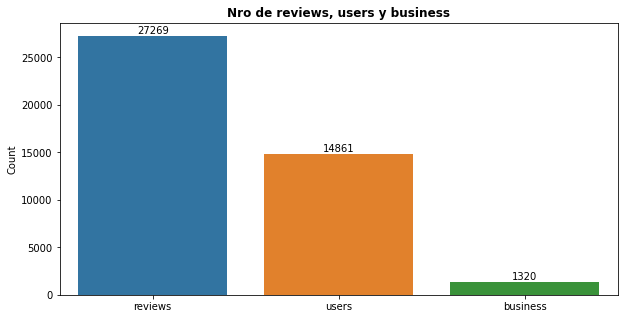

In [11]:
# Graficamos cantidad de reviews, users y business
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=['reviews', 'users', 'business'],
            y=[df['review_id'].nunique(), df['user_id'].nunique(), df['business_id'].nunique()])
plt.title('Nro de reviews, users y business', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.ylabel('Count')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

# Análisis de Business

Top 20 de business con más reviews

In [68]:
df_business = df.groupby('business_id').agg({'review_id':'count'}).sort_values(by="review_id", ascending=False).rename(columns = {'review_id':'cantidad'}).reset_index().head(20)
df_business

business_id  cantidad
0   3Q0QQPnHcJuX1DLCL9G9Cg      1067
1   mpDxBBGywUE6GRRKja3sBA       526
2   NeUf9FyCCIN4MEseNyqkXQ       387
3   jTGQUWGIVvL-aY03C5BEmw       291
4   NTfUFk8GyOLL1uPbEO-pVg       250
5   XmdTkxKyJd7TuDLoiic1kg       249
6   vgXE1I7c9ElcfYyZfQiN1Q       243
7   2X5G4Ujq0s4Wfn4TC7gX0g       243
8   2SwC8wqpZC4B9iFVTgYT9A       239
9   rgmptwPbBH1wLpiBHcbIhA       221
10  2Igiyhi82R8_QaaPplRmCw       213
11  MQnNtW1lHS-eid3QNUoUIw       212
12  CChwRoYVXA3QZulS8a6xOQ       211
13  ePP0Eqz8JKSbtdt2phiB4A       197
14  ym9QwkmB5ZKTyj7q5huTDw       189
15  dxCqGkhtXq-9fYEsX7Mf6Q       187
16  9SPwF-vRgtuHxciFxv5YLA       186
17  WuCcv_Dyd_1B_1-4jwK7sQ       182
18  TxKmAsKQjND5vbhBdUSyIA       180
19  xgK6AAhJ-cYBUCSaLzgTuw       173

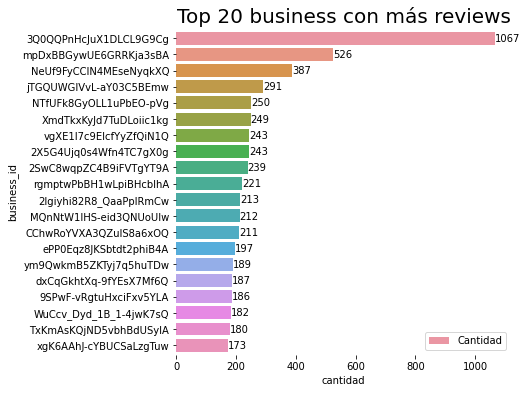

In [69]:
# Graficamos la tabla anterior.
f, ax = plt.subplots(figsize = (6,6))
ax = sns.barplot(y = "business_id", x = "cantidad", data = df_business,  label = 'Cantidad')
ax.bar_label(ax.containers[0])
ax.legend(ncol = 2, loc = 'lower right')
sns.despine(left = True, bottom = True)
ax.relim()
ax.autoscale_view()
ax.margins(y=0.01)

plt.title(label="Top 20 business con más reviews",
          fontsize=20,
          color="black")

plt.show()

Como vemos, dentro del top 20 de negocios con más reviews, el que menos tiene es 173.

A continuación mostramos la cantidad de reviews entre todos los negocios anteriores.

In [ ]:
df.groupby('business_id').agg({'review_id':'count'}).sort_values(by="review_id", ascending=False).rename(columns = {'review_id':'cantidad'}).reset_index().head(20).sum().cantidad

5650

Porcentaje de reviews de negocios más populares respecto al total.

In [ ]:
total_reviews = len(df)
negocios_con_mas_reviews = df.groupby('business_id').agg({'review_id':'count'}).sort_values(by="review_id", ascending=False).rename(columns = {'review_id':'cantidad'}).head(20).sum()
porcentaje = negocios_con_mas_reviews * 100 / total_reviews
print(f"{porcentaje.cantidad}%")

20.703554415536825%


Visualizamos distribución de algunos features

In [78]:
def graficar_countplot(df, features):
    ncount=len(df)    

    for i, feature in enumerate(features):

        plt.figure(figsize=(6,4))
        
        #ax = sns.countplot(x=df[feature], order=df[feature].value_counts().iloc[:10].index)
        ax = sns.countplot(x=feature, data = df, order=df[feature].value_counts().iloc[:10].index)
        ax.set_title(f'Countplot {feature}',fontdict={'fontsize': 12,'fontweight':'bold'})
        ax.tick_params(axis='x', rotation=45)
        
        
        for p in ax.patches:
            x=p.get_bbox().get_points()[:,0]
            y=p.get_bbox().get_points()[1,1]
            ax.annotate('   {:.2f}% '.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom',rotation=45)
        
        plt.xticks(rotation=90)
        plt.show()        

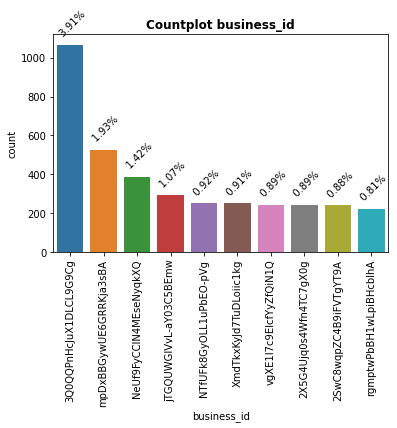

In [88]:
# Cant. de reviews por bussiness (10 primeros)
features = ['business_id']
graficar_countplot(df, features)

In [89]:
# Tabla: countplot stars
# b = df.groupby('business_id').agg({'review_id':'count'}).sort_values(by="review_id", ascending=False)
# df_total = pd.merge(df, b, how='inner', left_on='business_id', right_on='business_id')
# df_total = df_total[['stars','text']].groupby('stars').count().rename(columns = {'text':'cantidad'}).reset_index()
# df_total

Cantidad de reviews entre los 20 business más populares

In [90]:
df.groupby('business_id').agg({'review_id':'count'}).sort_values(by="review_id", ascending=False).rename(columns={'review_id':'cantidad'}).reset_index().head(20)

business_id  cantidad
0   3Q0QQPnHcJuX1DLCL9G9Cg      1067
1   mpDxBBGywUE6GRRKja3sBA       526
2   NeUf9FyCCIN4MEseNyqkXQ       387
3   jTGQUWGIVvL-aY03C5BEmw       291
4   NTfUFk8GyOLL1uPbEO-pVg       250
5   XmdTkxKyJd7TuDLoiic1kg       249
6   vgXE1I7c9ElcfYyZfQiN1Q       243
7   2X5G4Ujq0s4Wfn4TC7gX0g       243
8   2SwC8wqpZC4B9iFVTgYT9A       239
9   rgmptwPbBH1wLpiBHcbIhA       221
10  2Igiyhi82R8_QaaPplRmCw       213
11  MQnNtW1lHS-eid3QNUoUIw       212
12  CChwRoYVXA3QZulS8a6xOQ       211
13  ePP0Eqz8JKSbtdt2phiB4A       197
14  ym9QwkmB5ZKTyj7q5huTDw       189
15  dxCqGkhtXq-9fYEsX7Mf6Q       187
16  9SPwF-vRgtuHxciFxv5YLA       186
17  WuCcv_Dyd_1B_1-4jwK7sQ       182
18  TxKmAsKQjND5vbhBdUSyIA       180
19  xgK6AAhJ-cYBUCSaLzgTuw       173

# Análisis de Estrellas

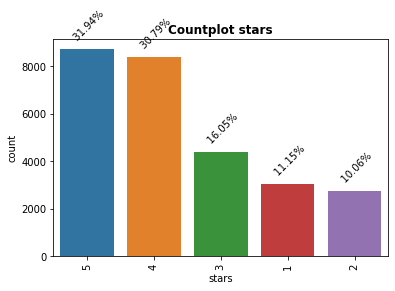

In [91]:
# Distribución del feature 'stars'.
features = ['stars']
graficar_countplot(df, features)

In [92]:
df[['stars','text']].groupby('stars').count().rename(columns = {'text':'cantidad'}).reset_index()

stars  cantidad
0      1      3041
1      2      2744
2      3      4378
3      4      8396
4      5      8710

Stars de las reviews de los 20 negocios más populares.

In [48]:
b = df.groupby('business_id').agg({'review_id':'count'}).sort_values(by="review_id", ascending=False).head(20)
df_aux = pd.merge(df, b, how='inner', left_on='business_id', right_on='business_id')

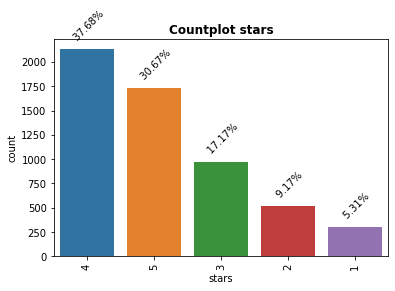

In [23]:
features = ['stars']
graficar_countplot(df_aux, features)

In [27]:
df_aux_tabla = df_aux[['stars','text']].groupby('stars').count().rename(columns = {'text':'cantidad'}).reset_index()
df_aux_tabla

stars  cantidad
0      1       300
1      2       518
2      3       970
3      4      2129
4      5      1733

Cantidad de usuarios que realizaron reviews sobre esos 20 negocios.

In [46]:
df_aux['user_id'].nunique()

4600

Negocios con más reviews con 5 estrellas.

In [137]:
df[df['stars'] == 5].groupby('business_id').agg({'stars':'count'}).sort_values(by="stars", ascending=False).rename(columns={'stars':'cant_5_estrellas'}).reset_index().head(10)

business_id  cant_5_estrellas
0  mpDxBBGywUE6GRRKja3sBA               175
1  3Q0QQPnHcJuX1DLCL9G9Cg               141
2  CChwRoYVXA3QZulS8a6xOQ               121
3  2Igiyhi82R8_QaaPplRmCw               120
4  2X5G4Ujq0s4Wfn4TC7gX0g               116
5  vgXE1I7c9ElcfYyZfQiN1Q               102
6  jTGQUWGIVvL-aY03C5BEmw                97
7  2SwC8wqpZC4B9iFVTgYT9A                89
8  r8jeeS3k_diihMDSu9IjlA                89
9  ePP0Eqz8JKSbtdt2phiB4A                86

Negocios con más reviews con 1 estrella.

In [138]:
df[df['stars'] == 1].groupby('business_id').agg({'stars':'count'}).sort_values(by="stars", ascending=False).rename(columns={'stars':'cant_1_estrellas'}).reset_index().head(10)

business_id  cant_1_estrellas
0  3Q0QQPnHcJuX1DLCL9G9Cg                79
1  eThu9hCL8NOjOxswQ-cFSg                67
2  vKtMsWeAaThimXGo9Ic_Og                60
3  wHi8ODv7TGmeUB02XoX-mA                41
4  mpDxBBGywUE6GRRKja3sBA                36
5  NeUf9FyCCIN4MEseNyqkXQ                36
6  9mwShpTgZofOujt4JfyGmw                29
7  MCFxbw9hQYejyvg59T44TA                23
8  n9iK0s1dKxv5JLi3u1eTkQ                21
9  6ilJq_05xRgek_8qUp36-g                21

# Análisis de Fechas

In [ ]:
# Fecha mínima
df['date'].min()

'2005-09-06'

In [ ]:
# Fecha máxima
df['date'].max()

'2015-12-24'

In [6]:
# Conevrtimos date a datetime
df['datetime'] = pd.to_datetime(df['date'])

In [7]:
# Obtemos el año de las reviews
df['year'] = df.datetime.dt.year

Cantidad de Reviews x Año

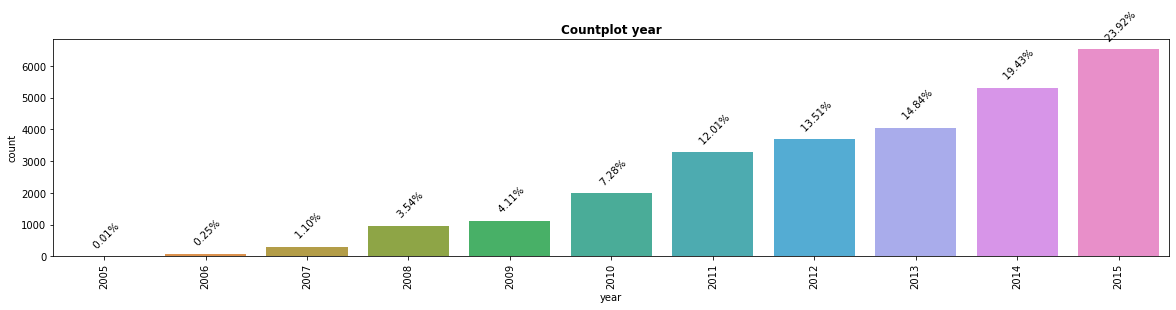

In [29]:
ncount=len(df)  
plt.figure(figsize=(20,4))
        
#ax = sns.countplot(x=df['year'], order=df['year'].value_counts().index)
ax = sns.countplot(x='year', data=df)
ax.set_title(f'Countplot year',fontdict={'fontsize': 12,'fontweight':'bold'})
ax.tick_params(axis='x', rotation=45)


for p in ax.patches:
  x=p.get_bbox().get_points()[:,0]
  y=p.get_bbox().get_points()[1,1]
  ax.annotate('   {:.2f}% '.format(100.*y/ncount), (x.mean(), y), 
      ha='center', va='bottom',rotation=45)

plt.xticks(rotation=90)
plt.show()

# Análisis de Votes

In [87]:
# Porcentaje de votes según stars.
df[['votes.cool','votes.funny','votes.useful','stars']].groupby('stars').mean()*100
# Ej: para star=1 tenemos 86% de votes.useful

votes.cool  votes.funny  votes.useful
stars                                       
1       13.679711    33.936205     86.090102
2       25.000000    37.099125     91.690962
3       41.091823    36.226587     80.721791
4       48.439733    32.467842     85.790853
5       42.858783    27.037887     77.807118

Cantidad de votes a lo largo del tiempo

In [31]:
df_votes = df[['votes.cool','votes.funny','votes.useful']].groupby(df.datetime.dt.year).sum().reset_index()
df_votes

datetime  votes.cool  votes.funny  votes.useful
0       2005           1            0             0
1       2006          39           40            69
2       2007         190          135           307
3       2008         538          399          1072
4       2009         939          700          1748
5       2010        1140         1052          2657
6       2011        1593         1491          3623
7       2012        1372         1293          3296
8       2013        1416         1208          3254
9       2014        1607         1113          3443
10      2015        1866         1286          3179

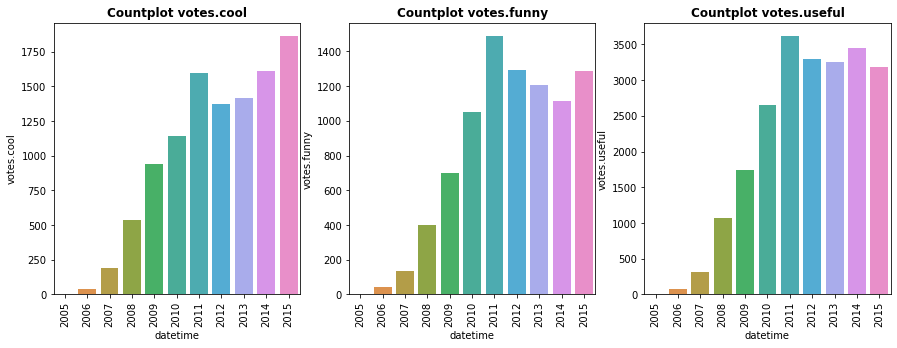

In [35]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(15, 5)
plt.xticks(rotation=45)

sns.barplot(x='datetime', y='votes.cool', data=df_votes,
             ax=axs[0])


sns.barplot(x='datetime', y='votes.funny', data=df_votes,
             ax=axs[1])

sns.barplot(x='datetime', y='votes.useful', data=df_votes,
             ax=axs[2])

axs[0].tick_params(axis='x', rotation=90)
axs[0].set_title('Countplot votes.cool', fontdict={'fontsize': 12,'fontweight':'bold'})

axs[1].tick_params(axis='x', rotation=90)
axs[1].set_title('Countplot votes.funny', fontdict={'fontsize': 12,'fontweight':'bold'})

axs[2].tick_params(axis='x', rotation=90)
axs[2].set_title('Countplot votes.useful', fontdict={'fontsize': 12,'fontweight':'bold'})

plt.show()

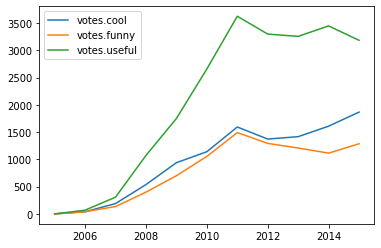

In [67]:
# create data
x = [10,20,30,40,50]
y = [30,30,30,30,30]
  
# plot lines
plt.plot(df_votes['datetime'], df_votes['votes.cool'], label = "votes.cool")
plt.plot(df_votes['datetime'], df_votes['votes.funny'], label = "votes.funny")
plt.plot(df_votes['datetime'], df_votes['votes.useful'], label = "votes.useful")
plt.legend()
plt.show()

¿Cuál es el texto de la review con votos cool?


In [ ]:
df.groupby('review_id').agg({'votes.cool':'sum'}).sort_values(by="votes.cool", ascending=False).head(1)

votes.cool
review_id                         
tIpUgffgjIoWYOx4Xjvi-Q          61

In [ ]:
df[df['review_id'] == 'tIpUgffgjIoWYOx4Xjvi-Q']['text']

3931    Three Birds left and pounds of Steel makes for good target practice! \n\nThe Pittsburgh Steelers have one of the best records in football history. They have won 5 out of 42 Super Bowls. Only 3 teams have won 5 and that is the Steelers, the Cowboys and the SF 49's. Seeing the Steelers are the only one of those three in the playoffs, they could break all records this year, by winning 6 Super Bowls. IF they go to the Super Bowl again this year, it will be their 7TH appearance.\n\nIF, is the biggest word in the English language. If my grandmother had 4 wheels, she would be a box car. \n\nI was not thrilled when Bill Cowher left the Steelers, but I must say Mike Tomlin has done a fine job and we were blessed, to have had two great coaches. \n\nI have been an avid collector of autographed sports memorabilia for many, many years. I have quite a lot of autographed Steelers merchandise, including a football jersey signed by the Steel Curtain. \n\nI can't help but admire that more and mo

¿Cuál es el texto de la review con votos funnny ?

In [ ]:
df.groupby('review_id').agg({'votes.funny':'sum'}).sort_values(by="votes.funny", ascending=False).head(1)

votes.funny
review_id                          
tIpUgffgjIoWYOx4Xjvi-Q           52

Vemos que se trata del mismo business anterior.

¿Cuál es el texto de la review con votos useful ?

In [ ]:
df.groupby('review_id').agg({'votes.useful':'sum'}).sort_values(by="votes.useful", ascending=False).head(1)

votes.useful
review_id                           
tIpUgffgjIoWYOx4Xjvi-Q            52

Vemos que se trata del mismo business anterior.

# Análisis de Usuarios

Cantidad de usuarios

In [ ]:
df['user_id'].nunique()

14861

Top 20 de usuarios que realizaron más reviews

In [ ]:
df[['user_id', 'review_id']].groupby('user_id').count().sort_values(by="review_id", ascending=False).rename(columns = {'review_id':'cantidad'}).reset_index().head(20)

user_id  cantidad
0   iTmWHtltCtk0Gm55AOxrUA       113
1   nEYPahVwXGD2Pjvgkm7QqQ        84
2   -_1ctLaz3jhPYc12hKXsEQ        82
3   q7MrNVt1FE23rwtWmPYWHg        69
4   UD7Y1CqfY6mDmRwIuCf6nA        68
5   VhI6xyylcAxi0wOy2HOX3w        66
6   bvu13GyOUwhEjPum2xjiqQ        61
7   hru2IDwSyN61sgWPtJw_hA        60
8   So32N7bSbUd1RwhFtI6jTQ        58
9   ts7EG6Zv2zdMDg29nyqGfA        57
10  RSExP0-Boucr4QyIEzZi0A        55
11  4G68oLRY3aHE5XUt_MUUcA        53
12  Q3fFv_ft17OyV-NRF1iQxw        51
13  lpZtfD-vCqUER1yGKEvUPw        49
14  DLu1Bum8EXNE62xno-v0VA        48
15  _vS9qNQvx8wVUOIkj4qfAg        47
16  WzaaorVCmUTQvu4mScunNg        47
17  9cCTmiJ7hz35rHIdr8n9kA        46
18  8ED8BPCXKXZnGsVMyl5Bhw        46
19  s9I4KMcrHKki44g_eTrYqQ        45

Reviews del usuario que más realizó reviews, agrupadas por negocio.

In [ ]:
df[df['user_id'] == 'iTmWHtltCtk0Gm55AOxrUA'][['business_id','user_id']].groupby('business_id').count().sort_values(by="user_id", ascending=False).rename(columns = {'user_id':'cantidad'}).reset_index().head(20)

business_id  cantidad
0   Bza-l75OiKcMRmTYILpyfQ         6
1   fB7XYJYrTtchlTmzSQVMbQ         5
2   j7kgLc4Uys_sb-H7_Velcg         4
3   KH6stvNdq_aV0HvKw8P5yA         4
4   Pu5uzlZ05pqVlx6LcZbfgw         3
5   uUorjstNslr3gkIsVGtQAg         3
6   JcP-IIrZkW_Yyv4a0yLRCw         3
7   2bBxE8pEbLBETejCi_aBeg         3
8   EPILrBqmgQxd-R1gZ1EWJg         3
9   XWLtYPhCpHht5Zn52zp3-Q         3
10  -KQ283hJkBO12u8XOrlCcQ         2
11  ISKLP0qxApATxRlUDob6Cg         2
12  J7I85lTCEGr9-qp6AXPUjQ         2
13  -TSFapUMwdyyxoi2egkOhw         2
14  bbfdJ1dkwWNww1m_SfyDnQ         2
15  Q9BXMPu2HnRDMq9X_2rHrQ         2
16  h5zKLqoNlMozvxdkRzSiYQ         2
17  l-OmDgEd4QkZpyXVpkp2yA         2
18  l6d9-LxY8gM6v7WxehHfwg         2
19  shrMOQmX_SX-KualwYoAzA         2

# Longitud de las reviews

In [9]:
def get_longitud_text(text):
  return len(text)

In [10]:
df['text_length'] = df['text'].apply(get_longitud_text)

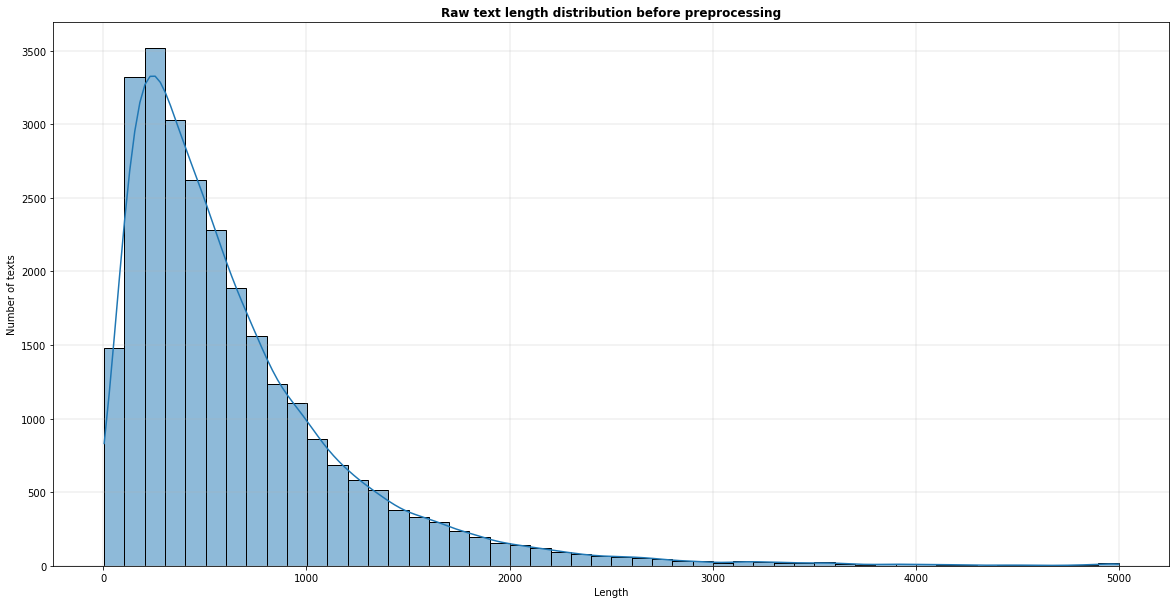

In [95]:
plt.figure(figsize=(20, 10))
sns.histplot(df['text_length'], kde=True, bins=50)
plt.title('Raw text length distribution before preprocessing', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.ylabel('Number of texts')
plt.xlabel('Length')
plt.grid(linewidth=0.3)
plt.show()

Longitud del texto vs stars

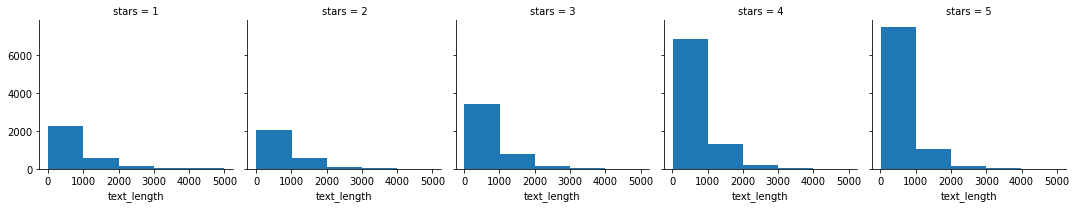

In [96]:
g=sns.FacetGrid(df,col='stars')
g.map(plt.hist,'text_length',bins=5)

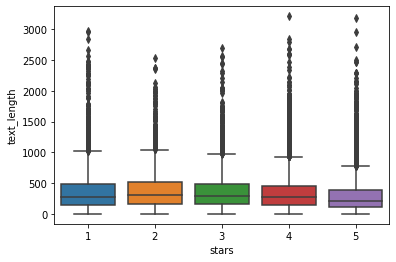

In [127]:
sns.boxplot(x='stars',y='text_length',data=df)

# Correlaciones entre variables

<AxesSubplot: >

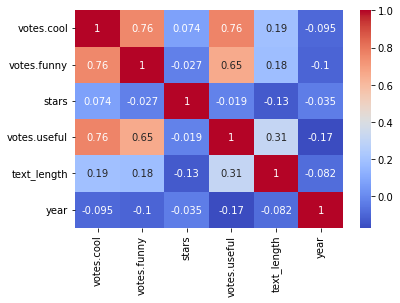

In [97]:
sns.heatmap(df.corr(),cmap='coolwarm',annot=True)

# Preprocessing (Preprocesamiento)

Vamos a trabajar con la librería Spacy para limpiar los textos de signos de puntuación y caracteres especiales.

In [11]:
import spacy
from bs4 import BeautifulSoup

In [12]:
#Instancio nlp
nlp = spacy.load("en_core_web_sm")

In [13]:
def clean_text(text):
  clean_text = []
  for token in nlp(text):
    if (
        not token.is_stop
        and not token.is_punct
        and not token.like_url
    ):
        clean_text.append(token.lemma_.lower())

  return " ".join(clean_text)

In [14]:
def remove_html(text):
  soup = BeautifulSoup(text)

  return soup.get_text()

In [15]:
# Tarda 10 minutos
df['text_clean']=df['text'].astype(str).apply(clean_text)

In [16]:
df['text_clean']=df['text_clean'].astype(str).apply(remove_html)

# WordCloud para el texto limpio de las reviews

Visualizamos con una wordcloud la frecuencia de palabras en las reviews.

In [42]:
from wordcloud import WordCloud, STOPWORDS
from scipy import stats

nlp.Defaults.stop_words.add("nan")

%matplotlib inline
def cloud(data,backgroundcolor = 'black', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

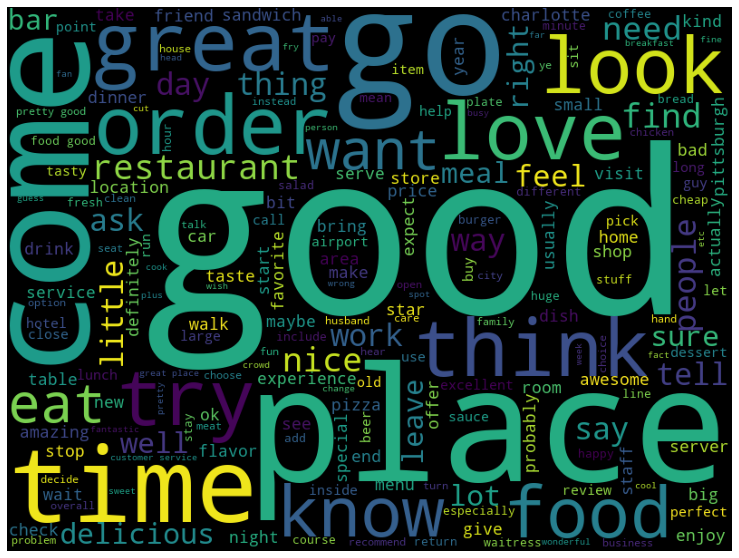

In [43]:
cloud(' '.join(df['text_clean']))

## Wordcloud para los 20 negocios más populares

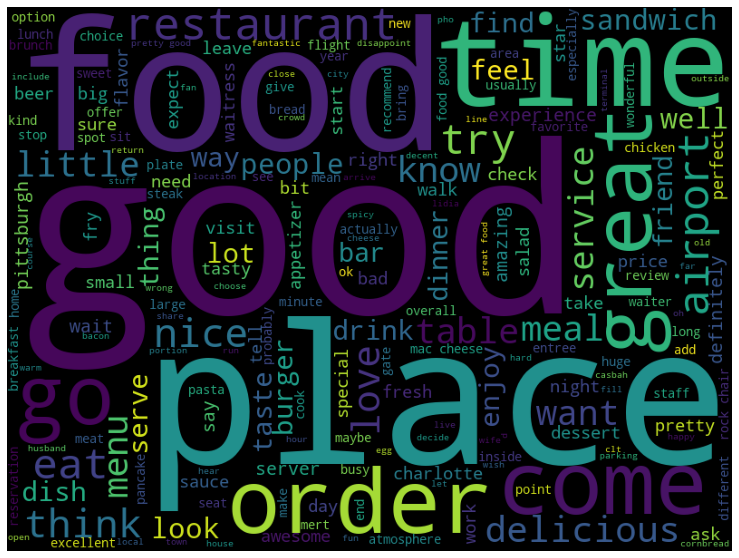

In [ ]:
a = df.groupby('business_id').agg({'review_id':'count'}).sort_values(by="review_id", ascending=False).head(20)
df_aux = pd.merge(df, a, how='inner', left_on='business_id', right_on='business_id')

cloud(' '.join(df_aux['text_clean']))

## Frecuencia de Palabras del texto de las Reviews

✅ Visualizamos la frecuencia de palabras y las clases del target.

In [ ]:
import plotly.express as px

In [ ]:
# tardo 3 minutos
FreqOfWords = df['text_clean'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0)
fig.update_layout(title_text='Top 200 palabras más frecuentes',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

# NER

Named entity recognition (NER) es una técnica de NLP que automáticamente identifica entidades en un texto y las clasifica en alguna categoría predefinida.

 Una entidad puede ser:
- Nombres de personas
- Organizaciones
- Ubicaciones
- Fechas
- Cantidades
- Valores monetarios
- Porcentajes
- Y más..

Utilizaremos spacy para extraer las entidades de reviews.

Primero que nada importamos spacy y cargamos el modelo que querramos usar, en este caso, inglés.

Definimos una función que recibiendo un texto (str), retorne un listado de entidades (solo el nombre de la entidad, es decir, .text)

In [14]:
def get_entities(text:str):
  doc=nlp(text)
  ents = []
  if doc.ents: 
    for ent in doc.ents:
      ents.append(ent.text)
  return ents

Aplicamos la función a todo el df y mostramos 10 filas al azar

In [15]:
df["NER"] = df["text_clean"].apply(get_entities)

In [86]:
df[['text', 'NER']].sample(10)

text  \
66     I've been informed by a fellow Yelper that the...   
4098   Adorable shop with tons stuff in every corner....   
21169  Swanky ambience, great service, great happy ho...   
18921  Great setting, amazing flavors. I had the salm...   
7164   There has to be better Italian food in Pittsbu...   
21989  Everytime I go here for a concert I appreciate...   
4442   Recently went back to give Cain's another shot...   
24660  Coyote Joes is a WONDERFUL place to enjoy your...   
2266   I drive 30 min to go to this particular Whole ...   
104    If you want a true understanding of Pittsburgh...   

                                                     NER  
66                                              [season]  
4098                                                  []  
21169  [hour, hour menu wild, flatbread calamari, gre...  
18921            [13 year old, saturday, night, 36 hour]  
7164   [italian, overnight, 2, 50, 8, tiramisu gross,...  
21989                                   [6 7, 4 5 month]  
4442                                            [second]  
24660                                            [night]  
2266                                   [30, south hills]  
104              [pittsburgh, morning, south city, half]

Aplicamos EXPLODE

En pandas, la función .explode() nos permite transformar una filas de un dataset que tienen una lista (como nuestra columna NER) en muchas filas (una por elemento en la lista).

Aplicamos dicha función a nuestra columna NER pero sin modificar el df original, guardando el resultado en otro df.


In [16]:
df_exploded = df.explode("NER")
df_exploded.head()

user_id               review_id  \
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                    text  \
0  Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.   
0  Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.   
0  Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.   
0  Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.   
0  Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.   

   votes.cool             business_id  votes.funny  stars        date    type  \
0           0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
0           0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
0           0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
0           0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
0           0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   

   votes.useful   datetime  year  \
0             0 2012-08-01  2012   
0             0 2012-08-01  2012   
0             0 2012-08-01  2012   
0             0 2012-08-01  2012   
0             0 2012-08-01  2012   

                                                                                                                                                                                                                                          

## Wordcloud de los NER

In [17]:
df_exploded['NER_NER'] = df_exploded['NER'].apply(lambda x : str(x or ""))

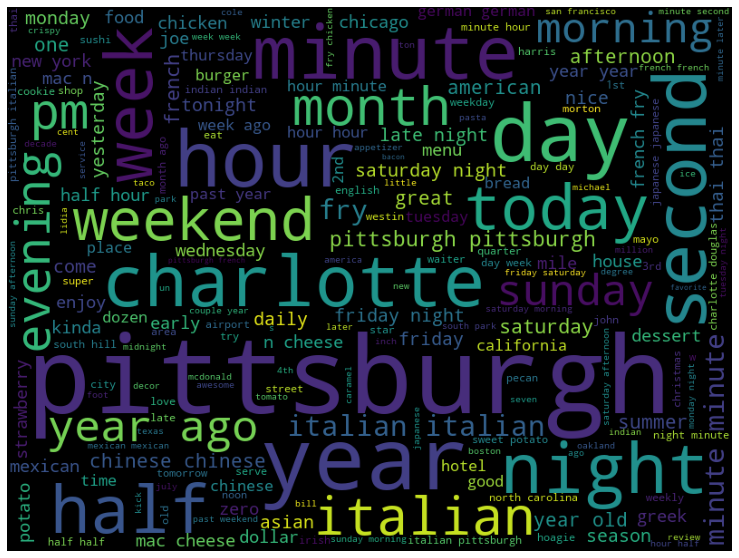

In [20]:
df_exploded = df_exploded[df_exploded['NER_NER'] != 'nan']
cloud(' '.join(df_exploded['NER_NER']))

Ahora, agrupando por NER podemos obtener cuáles son las entidades que aparecen más frecuentemente en estas reviews. 

Obtener el top 20 de entidades más frecuentes.

In [110]:
df_ner_exploded = df_exploded[df_exploded.NER.apply(lambda x: not x.isnumeric())][['review_id','NER']].groupby("NER").count().sort_values(by="review_id", ascending=False).rename(columns = {'review_id':'cantidad'}).reset_index().head(20)

In [111]:
df_ner_exploded

NER  cantidad
0   pittsburgh      2580
1      italian      1510
2        night      1115
3       second       999
4         half       875
5      chinese       868
6     saturday       849
7        today       749
8       french       671
9       sunday       638
10        hour       628
11        year       589
12      friday       544
13        thai       522
14         day       498
15     evening       476
16        week       463
17     weekend       427
18   charlotte       423
19      german       418

<AxesSubplot: xlabel='cantidad', ylabel='NER'>

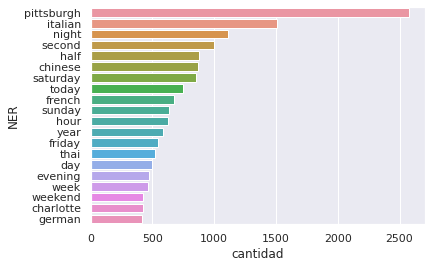

In [135]:
sns.barplot(data=df_ner_exploded, x="cantidad", y="NER")

Las primeras 20 reviews que están asociadas a más NERs



In [137]:
df_exploded.groupby('review_id').agg({'NER':'count'}).sort_values(by="NER", ascending=False).rename(columns = {'NER':'cantidad_NER'}).reset_index().head(20)

review_id  cantidad_NER
0   il2_VZrOfaOGWdoKOexafg            47
1   y1CRMEM3CUiq_QfYQprTaQ            44
2   gmP92zchkhe2BsWMgD8ZvA            42
3   ZBCU0lepUid9L9eONElWOw            39
4   geP98FFSfzaM6OfswlaHng            37
5   iSM4_uPt5ZEgVkgFPS0DTQ            36
6   ty-a__E7jrTxe34PyoUFvw            35
7   h3vo9HuYfIU3SGrqgS49vw            34
8   rHogJ02dqRKBgBFS7Lkheg            34
9   CT8xKB60OW4HNs71Gao-Tw            32
10  KaIwMCE4qOx7F3ico0ggbQ            32
11  vo0wkVE_UzH_lbkMo4Q9ng            30
12  ADL0evvRMtpsicpDnYfokA            30
13  kowF1gBVM3hOsM2RDG5pMA            29
14  cR6NSeyqKg9db2U-kPpTQA            29
15  FnARyq-F5C4hnYiSGpmaoQ            28
16  7GAcFg4nSnf0OqeAXRxekw            28
17  m3VSSRI4R0cXyCyrW9mPsA            27
18  dtRrKvlP7kzpb5SkXTaqeg            27
19  qM6afyD5OmP-Y7IbefcUQQ            27

A partir de las primeras 5 reviews con más NERs, buscamos cuáles son esas entidades.


```
il2_VZrOfaOGWdoKOexafg
y1CRMEM3CUiq_QfYQprTaQ
gmP92zchkhe2BsWMgD8ZvA
ZBCU0lepUid9L9eONElWOw
geP98FFSfzaM6OfswlaHng

```



In [21]:
mask = (df_exploded.review_id == 'il2_VZrOfaOGWdoKOexafg') | (df_exploded.review_id == 'y1CRMEM3CUiq_QfYQprTaQ') | (df_exploded.review_id == 'gmP92zchkhe2BsWMgD8ZvA') | (df_exploded.review_id == 'ZBCU0lepUid9L9eONElWOw') | (df_exploded.review_id == 'geP98FFSfzaM6OfswlaHng')

In [22]:
a = df_exploded[ mask ]

In [23]:
grouped = a[['NER','review_id']].groupby('NER', sort=True).count().reset_index()

grouped = grouped.rename(columns={'review_id':'cantidad'})

grouped = grouped[grouped.NER.apply(lambda x: not x.isnumeric())]

grouped.sort_values('cantidad', ascending=False).head(20)

NER  cantidad
94             ho ho        11
123            night         7
69      cherry house         6
88            friday         3
147           summer         3
105              joe         3
70           chinese         3
140           season         3
126   north carolina         3
60         afternoon         2
160             year         2
137          russian         2
149         thursday         2
157             week         2
52             75 54         2
139         saturday         2
47             60.00         2
141          serbian         2
158  week disposable         1
111        kraft mac         1

Top 20 de business con más NERs

In [27]:
# Cantidad de NER por negocio.
df_exploded.groupby("business_id").agg({'NER':'count'}).sort_values(by="NER", ascending=False).rename(columns={'NER':'cantidad_NER'}).reset_index().head(20)

business_id  cantidad_NER
0   3Q0QQPnHcJuX1DLCL9G9Cg          1907
1   mpDxBBGywUE6GRRKja3sBA          1107
2   NeUf9FyCCIN4MEseNyqkXQ          1105
3   XmdTkxKyJd7TuDLoiic1kg           920
4   rgmptwPbBH1wLpiBHcbIhA           871
5   n9iK0s1dKxv5JLi3u1eTkQ           813
6   2SwC8wqpZC4B9iFVTgYT9A           778
7   9SPwF-vRgtuHxciFxv5YLA           760
8   sxeuOMBRllOHXJTaUlI9kQ           692
9   NTfUFk8GyOLL1uPbEO-pVg           692
10  jTGQUWGIVvL-aY03C5BEmw           620
11  vgXE1I7c9ElcfYyZfQiN1Q           611
12  2_0P2AmSSFtPgddio0MgYA           598
13  WuCcv_Dyd_1B_1-4jwK7sQ           580
14  2X5G4Ujq0s4Wfn4TC7gX0g           578
15  2Igiyhi82R8_QaaPplRmCw           576
16  CChwRoYVXA3QZulS8a6xOQ           563
17  xgK6AAhJ-cYBUCSaLzgTuw           550
18  6-rJjW6ITl5o_FliiNgZRA           543
19  MQnNtW1lHS-eid3QNUoUIw           535

NERs asociadas a los business anteriores


In [33]:
df_exploded[['business_id','NER','user_id']].groupby(['business_id','NER']).count().sort_values(by="business_id", ascending=False).rename(columns={'user_id':'cantidad'}).reset_index().head(20)

business_id                      NER  cantidad
0   zxodsuIjtv3kx8mNa3sptQ                yesterday         1
1   zxodsuIjtv3kx8mNa3sptQ                      day         2
2   zxodsuIjtv3kx8mNa3sptQ           come later day         1
3   zxodsuIjtv3kx8mNa3sptQ                christmas         1
4   zxodsuIjtv3kx8mNa3sptQ           charlotte year         1
5   zxodsuIjtv3kx8mNa3sptQ  charlotte stylist color         1
6   zxodsuIjtv3kx8mNa3sptQ        charlotte dc area         1
7   zxodsuIjtv3kx8mNa3sptQ  bang little long afford         1
8   zxodsuIjtv3kx8mNa3sptQ                    asian         2
9   zxodsuIjtv3kx8mNa3sptQ                       80         1
10  zxodsuIjtv3kx8mNa3sptQ                       70         1
11  zxodsuIjtv3kx8mNa3sptQ                       65         1
12  zxodsuIjtv3kx8mNa3sptQ         6 week later day         1
13  zxodsuIjtv3kx8mNa3sptQ                       35         1
14  zxodsuIjtv3kx8mNa3sptQ                30 minute         1
15  zxodsuIjtv3kx8mNa3sptQ                       30         1
16  zxodsuIjtv3kx8mNa3sptQ                        3         2
17  zxodsuIjtv3kx8mNa3sptQ                22 minute         1
18  zxodsuIjtv3kx8mNa3sptQ                20 minute         1
19  zxodsuIjtv3kx8mNa3sptQ                        2         1

# Part of speech

POS es el proceso mediante el cual clasificamos a las palabras de un texto en categorías gramaticales. Para esto, los modelos se basan no solo en la palabra en sí, sino también en su contexto. Es decir, se busca identificar sustantivos, verbos, adjetivos, etc dentro de un texto. 

Al igual que NER, para identificar POS en en el texto de las reviews, utilizamos los modelos de spacy.



Definimos una función que dado un texto, retorne una lista de todos sus sustantivos. En caso de que no contenga sustantivos, debe retornar lista vacia.

In [105]:
def get_nouns(text):
  doc = nlp(text)
  nouns = []
  for token in doc:
    if token.pos_ == "NOUN":
      nouns.append(token.text)
  return nouns

In [106]:
df["NOUNS"] = df["text_clean"].apply(get_nouns)

Hacemos un explode, como hicimos con los NER

In [36]:
df_exploded_nouns = df.explode("NOUNS")
df_exploded_nouns.head()

user_id               review_id  \
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                    text  \
0  Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.   
0  Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.   
0  Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.   
0  Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.   
0  Mr Hoagie is an institution. Walking in, it does seem like a throwback to 30 years ago, old fashioned menu board, booths out of the 70s, and a large selection of food. Their speciality is the Italian Hoagie, and it is voted the best in the area year after year. I usually order the burger, while the patties are obviously cooked from frozen, all of the other ingredients are very fresh. Overall, its a good alternative to Subway, which is down the road.   

   votes.cool             business_id  votes.funny  stars        date    type  \
0           0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
0           0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
0           0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
0           0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
0           0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   

   votes.useful   datetime  year  \
0             0 2012-08-01  2012   
0             0 2012-08-01  2012   
0             0 2012-08-01  2012   
0             0 2012-08-01  2012   
0             0 2012-08-01  2012   

                                                                                                                                                                                                                                          

Cantidad de sustantivos por Negocio

In [38]:
df_exploded_nouns.groupby("business_id").agg({'NOUNS':'count'}).sort_values(by="NOUNS", ascending=False).rename(columns={'NOUNS':'cantidad_NOUNS'}).reset_index().head(20)

business_id  cantidad_NOUNS
0   3Q0QQPnHcJuX1DLCL9G9Cg           19730
1   mpDxBBGywUE6GRRKja3sBA           11323
2   2SwC8wqpZC4B9iFVTgYT9A            8076
3   XmdTkxKyJd7TuDLoiic1kg            7591
4   NeUf9FyCCIN4MEseNyqkXQ            7406
5   jTGQUWGIVvL-aY03C5BEmw            6628
6   n9iK0s1dKxv5JLi3u1eTkQ            6351
7   rgmptwPbBH1wLpiBHcbIhA            6247
8   9SPwF-vRgtuHxciFxv5YLA            5917
9   CChwRoYVXA3QZulS8a6xOQ            5866
10  2X5G4Ujq0s4Wfn4TC7gX0g            5810
11  NTfUFk8GyOLL1uPbEO-pVg            5766
12  vgXE1I7c9ElcfYyZfQiN1Q            5486
13  2Igiyhi82R8_QaaPplRmCw            5158
14  xgK6AAhJ-cYBUCSaLzgTuw            4882
15  MQnNtW1lHS-eid3QNUoUIw            4812
16  eaqJQP6bp7rQJQt5KqfvxQ            4466
17  OxIeMVcop5oxBUWANi-1Rw            4289
18  ym9QwkmB5ZKTyj7q5huTDw            4214
19  6-rJjW6ITl5o_FliiNgZRA            4060

Sustantivos más repetidos.

In [40]:
df_exploded_nouns[['NOUNS','user_id']].groupby("NOUNS").count().sort_values(by="user_id", ascending=False).rename(columns={'user_id':'cantidad'}).reset_index().head(20)

NOUNS  cantidad
0         food     14678
1        place     14096
2         time     11660
3      service      8796
4        order      8723
5   restaurant      5585
6        price      4960
7       people      4445
8        thing      4209
9          day      4172
10       staff      4109
11         bar      4099
12  experience      3887
13         lot      3803
14       table      3649
15        love      3601
16        room      3549
17       night      3537
18        year      3459
19         way      3377

### Wordcloud a partir de los sustantivos

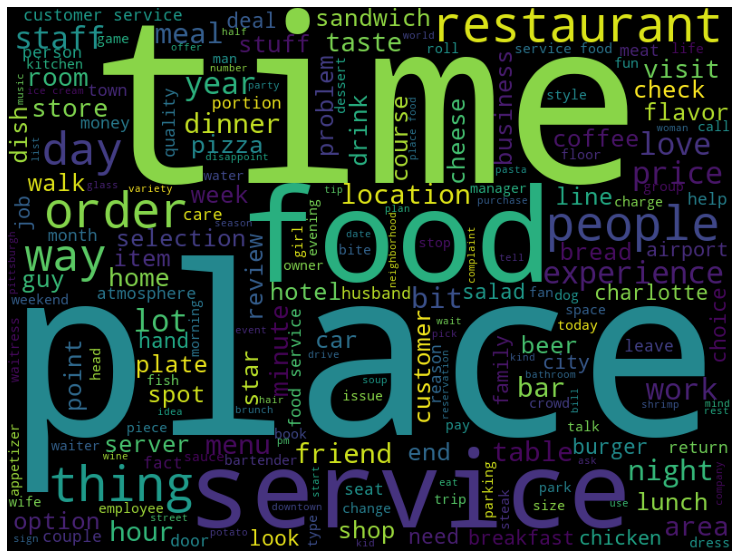

In [44]:
df_exploded_nouns['NOUNS'] = df_exploded_nouns['NOUNS'].apply(lambda x : str(x or ""))
cloud(' '.join(df_exploded_nouns['NOUNS']))

# Noun chunks

Spacy también nos permite extraer "noun chunks" de un texto.
Noun chunks son sustantivos en conjunto con cualquier palabra que dependa de ellos o los acompañe.

Creamos una función que dado un texto retornA un listado de noun chunks. Luego aplicamos la función al dataframe y almacenamos resultados en la columna "NOUN_CHUNKS"

In [45]:
def get_noun_chunks(text:str):
  doc = nlp(text)
  return [nc for nc in doc.noun_chunks]

In [46]:
df["NOUN_CHUNKS"] = df["text_clean"].apply(get_noun_chunks)

In [ ]:
df.head()

user_id               review_id  \
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
1  Iu6AxdBYGR4A0wspR9BYHA  KPvLNJ21_4wbYNctrOwWdQ   
2  auESFwWvW42h6alXgFxAXQ  fFSoGV46Yxuwbr3fHNuZig   
3  uK8tzraOp4M5u3uYrqIBXg  Di3exaUCFNw1V4kSNW5pgA   
4  I_47G-R2_egp7ME5u_ltew  0Lua2-PbqEQMjD9r89-asw   

                                                text  votes.cool  \
0  Mr Hoagie is an institution. Walking in, it do...           0   
1  Excellent food. Superb customer service. I mis...           0   
2  Yes this place is a little out dated and not o...           0   
3  All the food is great here. But the best thing...           0   
4  We checked this place out this past Monday for...           0   

              business_id  votes.funny  stars        date    type  \
0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
1  5UmKMjUEUNdYWqANhGckJw            0      5  2014-02-13  review   
2  5UmKMjUEUNdYWqANhGckJw            0      5  2015-10-31  review   
3  UsFtqoBl7naz8AVUBZMjQQ            0      5  2013-11-08  review   
4  UsFtqoBl7naz8AVUBZMjQQ            0      3  2014-03-29  review   

   votes.useful                                         text_clean  \
0             0  mr hoagie institution walk like throwback 30 y...   
1             0  excellent food superb customer service miss ma...   
2             0  yes place little date open weekend staff pleas...   
3             0  food great good thing wing wing simply fantast...   
4             0  check place past monday wing night hear wing g...   

                                                 NER  \
0  [hoagie, 30 year ago old, fashioned menu board...   
1                                           [superb]   
2                                    [weekend, year]   
3      [monday, wednesday, 0.75, dream   pittsburgh]   
4                                      [past monday]   

                                               NOUNS  \
0  [year, menu, selection, food, speciality, vote...   
1  [food, superb, customer, service, place, tradi...   
2  [date, weekend, staff, order, spot, veggie, ic...   
3  [food, thing, wing, wing, salt, wing, wing, ni...   
4  [place, wing, night, wing, decide, time, check...   

                                         NOUN_CHUNKS  
0  [(mr, hoagie, institution), (30, year, ago, ol...  
1  [(excellent, food, superb, customer, service, ...  
2  [(little, date, open, weekend, staff), (fast, ...  
3  [(food, great, good, thing, wing, wing), (seas...  
4  [(place), (monday, wing, night), (wing), (grea...

In [ ]:
df_exploded_nouns_chunks = df.explode("NOUN_CHUNKS")
df_exploded_nouns_chunks.head()

user_id               review_id  \
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
1  Iu6AxdBYGR4A0wspR9BYHA  KPvLNJ21_4wbYNctrOwWdQ   

                                                text  votes.cool  \
0  Mr Hoagie is an institution. Walking in, it do...           0   
0  Mr Hoagie is an institution. Walking in, it do...           0   
0  Mr Hoagie is an institution. Walking in, it do...           0   
0  Mr Hoagie is an institution. Walking in, it do...           0   
1  Excellent food. Superb customer service. I mis...           0   

              business_id  votes.funny  stars        date    type  \
0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
1  5UmKMjUEUNdYWqANhGckJw            0      5  2014-02-13  review   

   votes.useful                                         text_clean  \
0             0  mr hoagie institution walk like throwback 30 y...   
0             0  mr hoagie institution walk like throwback 30 y...   
0             0  mr hoagie institution walk like throwback 30 y...   
0             0  mr hoagie institution walk like throwback 30 y...   
1             0  excellent food superb customer service miss ma...   

                                                 NER  \
0  [hoagie, 30 year ago old, fashioned menu board...   
0  [hoagie, 30 year ago old, fashioned menu board...   
0  [hoagie, 30 year ago old, fashioned menu board...   
0  [hoagie, 30 year ago old, fashioned menu board...   
1                                           [superb]   

                                               NOUNS  \
0  [year, menu, selection, food, speciality, vote...   
0  [year, menu, selection, food, speciality, vote...   
0  [year, menu, selection, food, speciality, vote...   
0  [year, menu, selection, food, speciality, vote...   
1  [food, superb, customer, service, place, tradi...   

                                         NOUN_CHUNKS  
0                          (mr, hoagie, institution)  
0  (30, year, ago, old, fashioned, menu, board, b...  
0                                    (burger, patty)  
0  (frozen, ingredient, fresh, overall, good, alt...  
1  (excellent, food, superb, customer, service, m...

# Sentiment Analysis (Análisis de Sentimiento)

Para análisis de sentimientos utilizamos textblob.

In [98]:
from textblob import TextBlob

Definimos una función get_sentiment que dado un texto, nos retorne:
- la palabra "POS" si polarity > 0.1
- la palabra "NEU" si polarity ≥ -0.1 & polarity ≤ 0.1
- la palabra "NEG" si polarity < -0.1

Luego aplicarla a todo el df y almacenar resultados en la columna "SENTIMENT"

In [99]:
def get_sentiment(text):
  sent = TextBlob(text).sentiment.polarity

  if sent > 0.1:
    return "POS"
  
  if sent >= -0.1 and sent <= 0.1:
    return "NEU"

  if sent < 0.1:
    return "NEG"

In [100]:
df["SENTIMENT"] = df["text_clean"].apply(get_sentiment)

In [ ]:
df.head()

user_id               review_id  \
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
1  Iu6AxdBYGR4A0wspR9BYHA  KPvLNJ21_4wbYNctrOwWdQ   
2  auESFwWvW42h6alXgFxAXQ  fFSoGV46Yxuwbr3fHNuZig   
3  uK8tzraOp4M5u3uYrqIBXg  Di3exaUCFNw1V4kSNW5pgA   
4  I_47G-R2_egp7ME5u_ltew  0Lua2-PbqEQMjD9r89-asw   

                                                text  votes.cool  \
0  Mr Hoagie is an institution. Walking in, it do...           0   
1  Excellent food. Superb customer service. I mis...           0   
2  Yes this place is a little out dated and not o...           0   
3  All the food is great here. But the best thing...           0   
4  We checked this place out this past Monday for...           0   

              business_id  votes.funny  stars        date    type  \
0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
1  5UmKMjUEUNdYWqANhGckJw            0      5  2014-02-13  review   
2  5UmKMjUEUNdYWqANhGckJw            0      5  2015-10-31  review   
3  UsFtqoBl7naz8AVUBZMjQQ            0      5  2013-11-08  review   
4  UsFtqoBl7naz8AVUBZMjQQ            0      3  2014-03-29  review   

   votes.useful                                         text_clean  \
0             0  mr hoagie institution walk like throwback 30 y...   
1             0  excellent food superb customer service miss ma...   
2             0  yes place little date open weekend staff pleas...   
3             0  food great good thing wing wing simply fantast...   
4             0  check place past monday wing night hear wing g...   

                                                 NER  \
0  [hoagie, 30 year ago old, fashioned menu board...   
1                                           [superb]   
2                                    [weekend, year]   
3      [monday, wednesday, 0.75, dream   pittsburgh]   
4                                      [past monday]   

                                               NOUNS  \
0  [year, menu, selection, food, speciality, vote...   
1  [food, superb, customer, service, place, tradi...   
2  [date, weekend, staff, order, spot, veggie, ic...   
3  [food, thing, wing, wing, salt, wing, wing, ni...   
4  [place, wing, night, wing, decide, time, check...   

                                         NOUN_CHUNKS SENTIMENT  
0  [(mr, hoagie, institution), (30, year, ago, ol...       POS  
1  [(excellent, food, superb, customer, service, ...       POS  
2  [(little, date, open, weekend, staff), (fast, ...       POS  
3  [(food, great, good, thing, wing, wing), (seas...       POS  
4  [(place), (monday, wing, night), (wing), (grea...       NEU

Cuantos reviews asociadas a sentimientos (POS, NEU, NEG)

In [101]:
df_copy = df[['SENTIMENT','user_id']].copy()
df_copy = df_copy.rename(columns = {'user_id' : 'cantidad_reviews'})
a = df_copy.groupby("SENTIMENT").count()
a

cantidad_reviews
SENTIMENT                  
NEG                    1902
NEU                    4914
POS                   20453

*Gráfico* de torta a partir de los datos anteriores

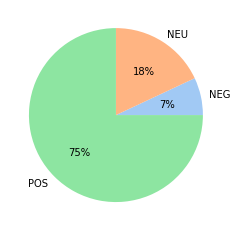

In [103]:
data = a.cantidad_reviews
labels = ['NEG','NEU','POS']

colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

Polaridad y Subjetividad de las reviews

In [54]:
def get_polarity(text):
  return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
  return TextBlob(text).sentiment.subjectivity


In [ ]:
df["polarity"] = df["text_clean"].apply(get_polarity)

In [ ]:
df["subjectivity"] = df["text_clean"].apply(get_subjectivity)

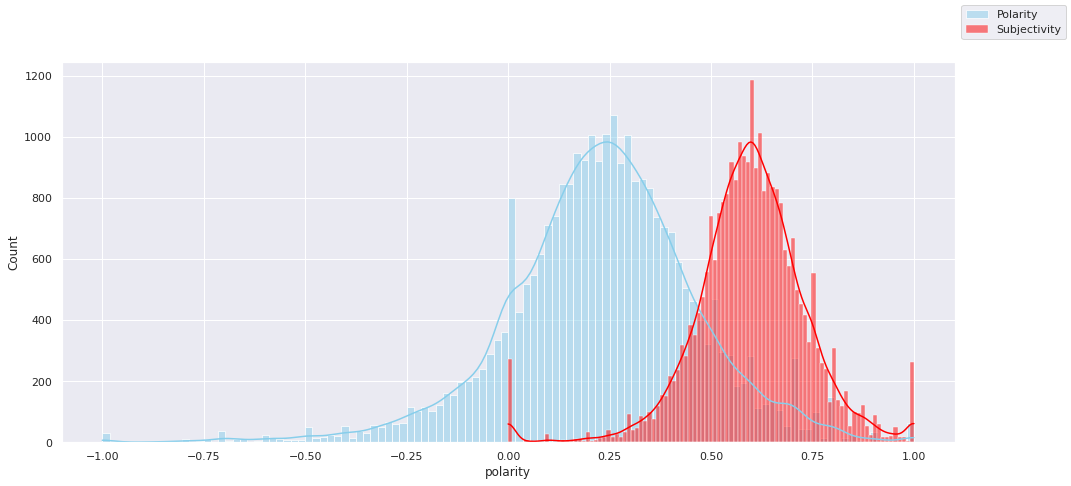

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
plt = plt.figure(figsize=(16, 7))
sns.set(style="darkgrid")

sns.histplot(data=df, x="polarity", color="skyblue", label="Polarity", kde=True)
sns.histplot(data=df, x="subjectivity", color="red", label="Subjectivity", kde=True)

plt.legend() 
plt.show()

In [ ]:
# Promedio de polaridad
df['polarity'].mean()

0.2305548167439731

In [ ]:
# Desviación Estándar de polaridad
df['polarity'].std()

0.23600174830705872

In [ ]:
# Promedio de subjetividad
df['subjectivity'].mean()

0.5969570102958797

In [ ]:
# Desviación Estándar de subjetividad
df['subjectivity'].std()

0.1409111442549212

*Vemos que la subjetividad y la polaridad estan un poco sesgadas hacia la derecha, lo cuál estaría indicando la presencia de reviews con sentimientos positivos.*

##### Agrupamos Sustantivas y Sentimientos

In [109]:
noun_sentiments = df.explode("NOUNS").groupby(["NOUNS", "SENTIMENT"], as_index=False).agg({"text_clean": "count"}).sort_values(by="NOUNS", ascending=False).rename(columns={'text_clean':'cantidad'})
noun_sentiments.sample(20)

NOUNS SENTIMENT  cantidad
21042        roman       POS         2
839         alleck       NEU         1
18260       pigeon       NEU         2
10008     football       POS        99
17391        paint       POS        90
17745       paulie       POS         1
3474        bucket       POS        34
7849        doggie       POS         5
15235   medication       NEU        10
25510        torch       POS         7
8492   electricity       NEG         1
14742  maintenance       NEU        47
18626           po       NEU         1
10903         good       POS       406
13577        kings       POS         3
13188  italian(ish       POS         1
23412    spreadout       POS         1
5379       collard       NEG         1
1178         appal       NEG         2
7346          dial       NEU         6

##### Sustantivos asociados a reviews más negativas

In [110]:
noun_sentiments[noun_sentiments.SENTIMENT == "NEG"].sort_values(by="cantidad", ascending=False).head(10)

NOUNS SENTIMENT  cantidad
9977         food       NEG       927
17031       order       NEG       807
25285        time       NEG       771
22003     service       NEG       751
18445       place       NEG       685
6661     customer       NEG       325
15632      minute       NEG       316
17919      people       NEG       315
9081   experience       NEG       308
6843          day       NEG       281

##### Sustantivos asociados a reviews más positivas

In [64]:
noun_sentiments[noun_sentiments.SENTIMENT == "POS"].sort_values(by="cantidad", ascending=False).head(10)

NOUNS SENTIMENT  cantidad
9979         food       POS     10896
18448       place       POS     10831
25288        time       POS      8276
22006     service       POS      6397
17034       order       POS      5893
20621  restaurant       POS      4321
19128       price       POS      3857
23523       staff       POS      3242
14513        love       POS      3213
2003          bar       POS      3201

##### Negocio con más comentarios positivos

In [67]:
df[df.SENTIMENT == "POS"][['SENTIMENT','business_id', 'text_clean']].groupby(['business_id', 'SENTIMENT']).count().sort_values(by="text_clean", ascending=False).rename(columns={'text_clean':'cantidad'}).reset_index().head(20)

business_id SENTIMENT  cantidad
0   3Q0QQPnHcJuX1DLCL9G9Cg       POS       740
1   mpDxBBGywUE6GRRKja3sBA       POS       389
2   NeUf9FyCCIN4MEseNyqkXQ       POS       273
3   jTGQUWGIVvL-aY03C5BEmw       POS       259
4   NTfUFk8GyOLL1uPbEO-pVg       POS       230
5   2SwC8wqpZC4B9iFVTgYT9A       POS       217
6   2X5G4Ujq0s4Wfn4TC7gX0g       POS       214
7   XmdTkxKyJd7TuDLoiic1kg       POS       210
8   vgXE1I7c9ElcfYyZfQiN1Q       POS       201
9   CChwRoYVXA3QZulS8a6xOQ       POS       200
10  MQnNtW1lHS-eid3QNUoUIw       POS       188
11  2Igiyhi82R8_QaaPplRmCw       POS       187
12  ePP0Eqz8JKSbtdt2phiB4A       POS       184
13  rgmptwPbBH1wLpiBHcbIhA       POS       183
14  9SPwF-vRgtuHxciFxv5YLA       POS       170
15  TxKmAsKQjND5vbhBdUSyIA       POS       159
16  ym9QwkmB5ZKTyj7q5huTDw       POS       146
17  dxCqGkhtXq-9fYEsX7Mf6Q       POS       146
18  xgK6AAhJ-cYBUCSaLzgTuw       POS       145
19  OxIeMVcop5oxBUWANi-1Rw       POS       143

##### Sentimientos de las reviews de c/u de los primeros 5 negocios anteriores.

In [115]:
df_aux_1 = df[df['business_id'] == '3Q0QQPnHcJuX1DLCL9G9Cg'][['SENTIMENT','user_id']].groupby("SENTIMENT").count()
df_aux_2 = df[df['business_id'] == 'mpDxBBGywUE6GRRKja3sBA'][['SENTIMENT','user_id']].groupby("SENTIMENT").count()
df_aux_3 = df[df['business_id'] == 'NeUf9FyCCIN4MEseNyqkXQ'][['SENTIMENT','user_id']].groupby("SENTIMENT").count()
df_aux_4 = df[df['business_id'] == 'jTGQUWGIVvL-aY03C5BEmw'][['SENTIMENT','user_id']].groupby("SENTIMENT").count()
df_aux_5 = df[df['business_id'] == 'NTfUFk8GyOLL1uPbEO-pVg'][['SENTIMENT','user_id']].groupby("SENTIMENT").count()

In [130]:
def grafico_torta_positivos(df_aux, business_id):
  fig = plt.figure(figsize=(8,8))

  data = df_aux.user_id
  labels = ['NEG','NEU','POS']

  #define Seaborn color palette to use
  colors = sns.color_palette('pastel')[0:5]

    #create pie chart
  plt.title('business_id: ' + business_id + " - " + 'Cant. reviews' + str(data.sum()) )

  
  plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
  plt.show()

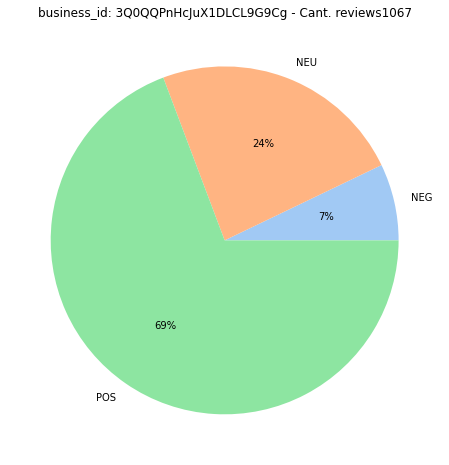

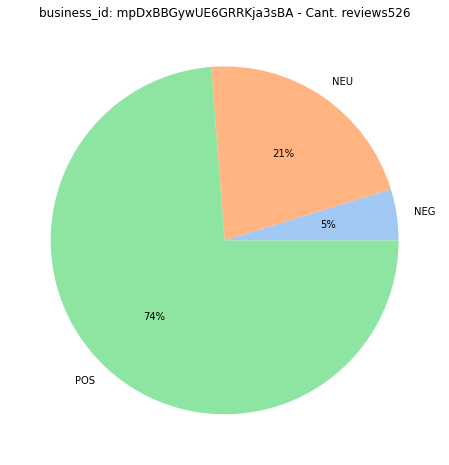

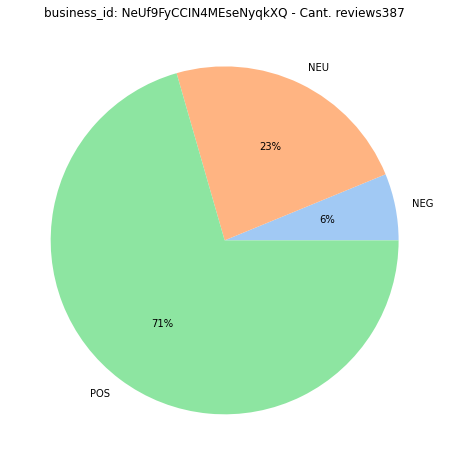

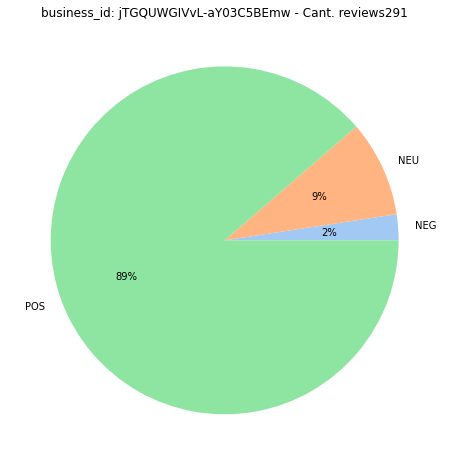

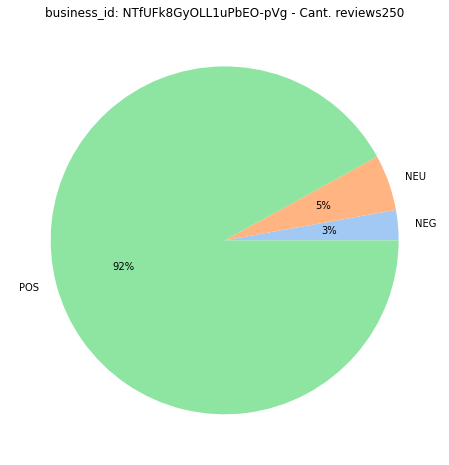

In [131]:
grafico_torta_positivos(df_aux_1,'3Q0QQPnHcJuX1DLCL9G9Cg')
grafico_torta_positivos(df_aux_2, 'mpDxBBGywUE6GRRKja3sBA')
grafico_torta_positivos(df_aux_3, 'NeUf9FyCCIN4MEseNyqkXQ')
grafico_torta_positivos(df_aux_4, 'jTGQUWGIVvL-aY03C5BEmw')
grafico_torta_positivos(df_aux_5, 'NTfUFk8GyOLL1uPbEO-pVg')

Estrellas de las reviews asociadas a los business anteriores.

In [120]:
df_aux_1_stars = df[df['business_id'] == '3Q0QQPnHcJuX1DLCL9G9Cg'][['stars','user_id']].groupby("stars").count()
df_aux_2_stars = df[df['business_id'] == 'mpDxBBGywUE6GRRKja3sBA'][['stars','user_id']].groupby("stars").count()
df_aux_3_stars = df[df['business_id'] == 'NeUf9FyCCIN4MEseNyqkXQ'][['stars','user_id']].groupby("stars").count()
df_aux_4_stars = df[df['business_id'] == 'jTGQUWGIVvL-aY03C5BEmw'][['stars','user_id']].groupby("stars").count()
df_aux_5_stars = df[df['business_id'] == 'NTfUFk8GyOLL1uPbEO-pVg'][['stars','user_id']].groupby("stars").count()

In [128]:
def grafico_torta_positivos_estrellas(df_aux, business_id):
  fig = plt.figure(figsize=(8,8))

  data = df_aux.user_id
  labels = ['1','2','3','4','5']

  #define Seaborn color palette to use
  colors = sns.color_palette('pastel')[0:5]

    #create pie chart
  plt.title('business_id: ' + business_id + " - Cant. reviews: " + str(data.sum()) )

  
  plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
  plt.show()

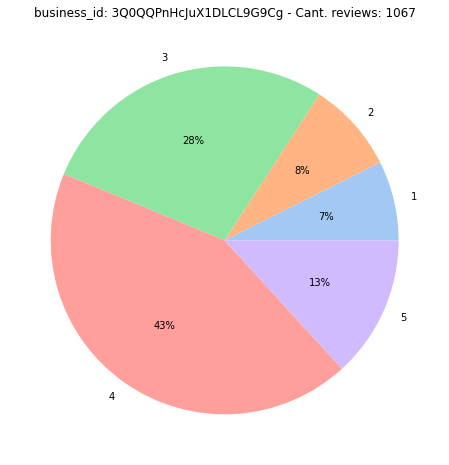

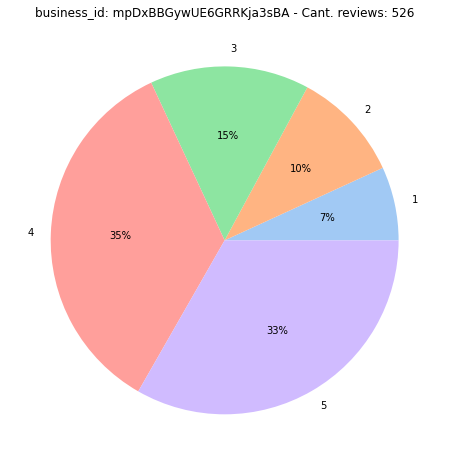

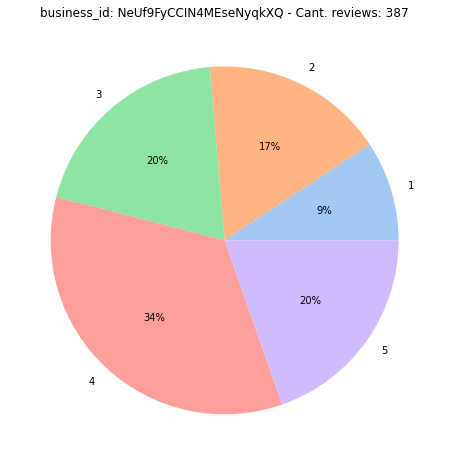

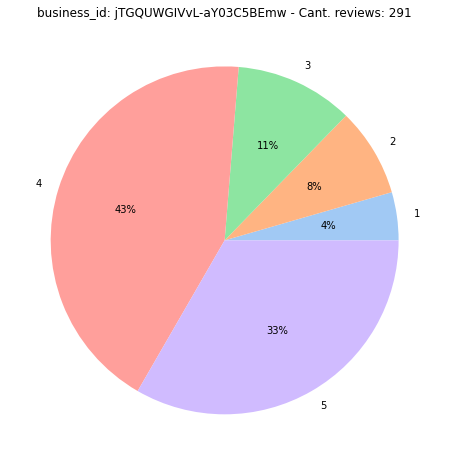

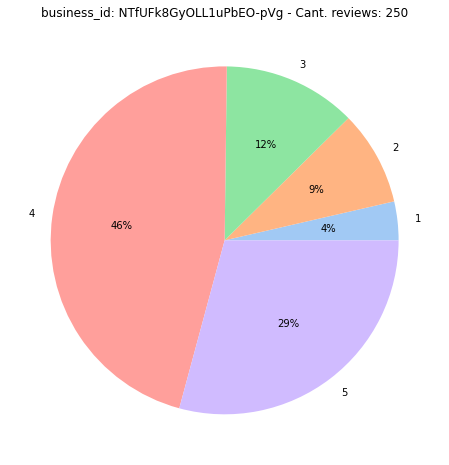

In [129]:
grafico_torta_positivos_estrellas(df_aux_1_stars,'3Q0QQPnHcJuX1DLCL9G9Cg')
grafico_torta_positivos_estrellas(df_aux_2_stars, 'mpDxBBGywUE6GRRKja3sBA')
grafico_torta_positivos_estrellas(df_aux_3_stars, 'NeUf9FyCCIN4MEseNyqkXQ')
grafico_torta_positivos_estrellas(df_aux_4_stars, 'jTGQUWGIVvL-aY03C5BEmw')
grafico_torta_positivos_estrellas(df_aux_5_stars, 'NTfUFk8GyOLL1uPbEO-pVg')

##### Negocios con más comentarios negativos

In [76]:
df[df.SENTIMENT == "NEG"][['SENTIMENT','business_id', 'text_clean']].groupby(['business_id', 'SENTIMENT']).count().sort_values(by="text_clean", ascending=False).rename(columns={'text_clean':'cantidad'}).reset_index().head(20)

business_id SENTIMENT  cantidad
0   3Q0QQPnHcJuX1DLCL9G9Cg       NEG        76
1   vKtMsWeAaThimXGo9Ic_Og       NEG        35
2   eThu9hCL8NOjOxswQ-cFSg       NEG        28
3   wHi8ODv7TGmeUB02XoX-mA       NEG        26
4   mpDxBBGywUE6GRRKja3sBA       NEG        25
5   NeUf9FyCCIN4MEseNyqkXQ       NEG        24
6   sbW8qHJgzEIH42B0S-3New       NEG        19
7   ym9QwkmB5ZKTyj7q5huTDw       NEG        17
8   9mwShpTgZofOujt4JfyGmw       NEG        17
9   Q9BXMPu2HnRDMq9X_2rHrQ       NEG        13
10  vgXE1I7c9ElcfYyZfQiN1Q       NEG        12
11  dxCqGkhtXq-9fYEsX7Mf6Q       NEG        11
12  n9iK0s1dKxv5JLi3u1eTkQ       NEG        11
13  WuCcv_Dyd_1B_1-4jwK7sQ       NEG        11
14  MMNBgMQCdwyVoNaHg0h_QA       NEG        11
15  XmdTkxKyJd7TuDLoiic1kg       NEG        11
16  FtjvnLhh51ZBYEpKAARaFQ       NEG        11
17  z4cCguoHdU48pj6sXMIzqg       NEG        11
18  4CPrhBc4Ado90fj7PG6jrA       NEG        10
19  X-uPUUV7xPiKivsQzJD-wg       NEG        10

Vemos que el primer negocio más negativo corresponde con el primer negocio más positivo.

In [80]:
# Sentimientos asociados al business_id 'vKtMsWeAaThimXGo9Ic_Og'
df_aux = df[df['business_id'] == 'vKtMsWeAaThimXGo9Ic_Og'][['SENTIMENT','user_id']].groupby("SENTIMENT").count().rename(columns={'user_id':'cantidad'}).reset_index()
df_aux.head()

SENTIMENT  cantidad
0       NEG        35
1       NEU        25
2       POS        17

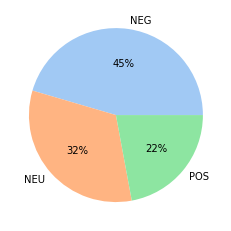

In [81]:
# Gráficamos los datos anteriores.

data = df_aux.cantidad
labels = ['NEG','NEU','POS']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

Sentimientos a lo largo del tiempo

In [134]:
df_copy = df[(df.SENTIMENT == 'POS') & (df.business_id == '3Q0QQPnHcJuX1DLCL9G9Cg')].copy()

In [83]:
df_copy.shape

(740, 17)

In [92]:
df_copy['year'].value_counts().iloc[:10].sort_index()

2006      2
2007      4
2008     26
2009     20
2010     52
2011    101
2012    115
2013    123
2014    162
2015    135
Name: year, dtype: int64

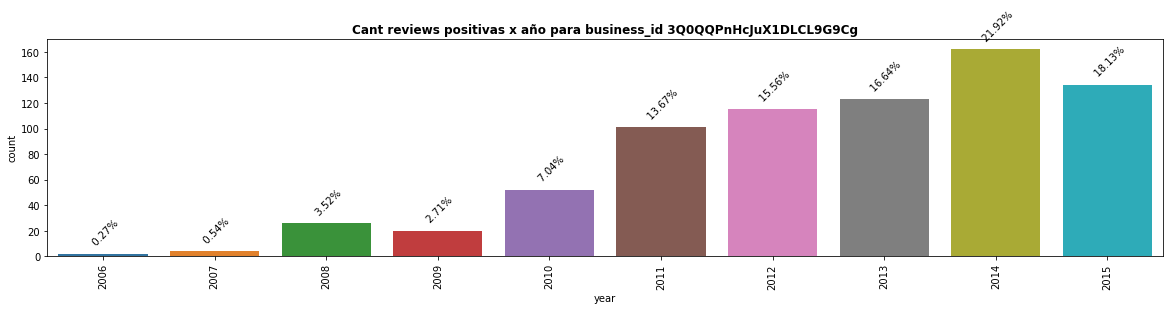

In [136]:
ncount=len(df_copy)    

plt.figure(figsize=(20,4))

#ax = sns.countplot(x=df_copy['year'], order=df_copy['year'].value_counts().iloc[:10].index)
ax = sns.countplot(x='year', data=df_copy)
ax.set_title(f'Cant reviews positivas x año para business_id 3Q0QQPnHcJuX1DLCL9G9Cg',fontdict={'fontsize': 12,'fontweight':'bold'})
ax.tick_params(axis='x', rotation=45)


for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('   {:.2f}% '.format(100.*y/ncount), (x.mean(), y), 
        ha='center', va='bottom',rotation=45)

plt.xticks(rotation=90)
plt.show()

##### Sentiments vs Stars

In [139]:
def set_sentimiento(star:int):
  if( star == 1 or star == 2 ): return 'NEG'
  if( star == 3 ): return 'NEU'
  return 'POS'

Convertimos star a sentimiento

In [140]:
df['star_sentiment'] = df['stars'].apply(set_sentimiento)

Distribución de sentimientos en todo el dataset

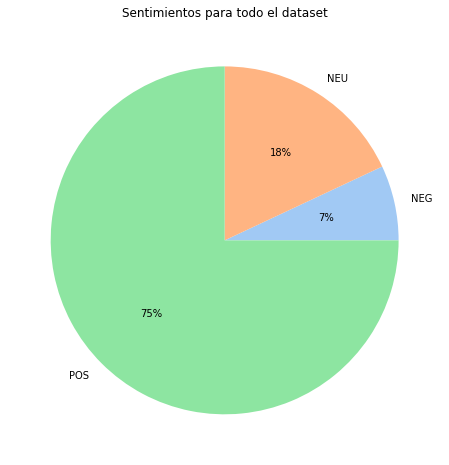

In [148]:
# Distribución de sentimientos en todo el dataset
df_stars = df[['SENTIMENT','text']].groupby('SENTIMENT').count().rename(columns={'text':'cantidad'}).reset_index()

data = df_stars.cantidad
labels = df_stars.SENTIMENT

#define Seaborn color palette to use
plt.figure(figsize=(8,8))
plt.title("Sentimientos para todo el dataset")
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

##### Distribución de star_sentiment en todo el dataset

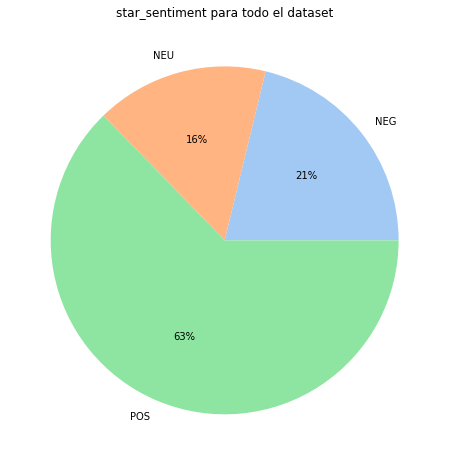

In [149]:
df_stars_sentiments = df[['star_sentiment','text']].groupby('star_sentiment').count().reset_index().rename(columns={'text':'cantidad'})

data = df_stars_sentiments.cantidad
labels = df_stars_sentiments.star_sentiment

#define Seaborn color palette to use
plt.figure(figsize=(8,8))
plt.title("star_sentiment para todo el dataset")
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

###### Sentimientos de las reviews del usuario con más reviews

In [ ]:
df[df['user_id'] == 'iTmWHtltCtk0Gm55AOxrUA'][['user_id','SENTIMENT']].groupby('SENTIMENT').count().reset_index().rename(columns = {'user_id': 'cantidad'})

SENTIMENT  cantidad
0       NEG         4
1       NEU        30
2       POS        79

###### Reviews positivas agrupadas por usuarios

In [ ]:
df[df['SENTIMENT'] == 'POS'][['user_id','review_id']].groupby('user_id').count().sort_values(by="review_id", ascending=False).reset_index().rename(columns = {'review_id': 'cantidad'}).head(5)

user_id  cantidad
0  iTmWHtltCtk0Gm55AOxrUA        79
1  nEYPahVwXGD2Pjvgkm7QqQ        69
2  q7MrNVt1FE23rwtWmPYWHg        55
3  ts7EG6Zv2zdMDg29nyqGfA        50
4  VhI6xyylcAxi0wOy2HOX3w        50

# KeyBERT

Ahora vamos a analizar las keywords.

In [156]:
kw_model = KeyBERT()

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

- Top n: Cantidad de keywords por review
- keyphrase_ngram_range: Cantidad de palabras por keyword (keyphrase)

In [158]:
df["KEYWORDS"] = df['text_clean'].apply(lambda x: kw_model.extract_keywords(x, top_n=3, keyphrase_ngram_range=(1,1)))

In [161]:
df.head()

user_id               review_id  \
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
1  Iu6AxdBYGR4A0wspR9BYHA  KPvLNJ21_4wbYNctrOwWdQ   
2  auESFwWvW42h6alXgFxAXQ  fFSoGV46Yxuwbr3fHNuZig   
3  uK8tzraOp4M5u3uYrqIBXg  Di3exaUCFNw1V4kSNW5pgA   
4  I_47G-R2_egp7ME5u_ltew  0Lua2-PbqEQMjD9r89-asw   

                                                text  votes.cool  \
0  Mr Hoagie is an institution. Walking in, it do...           0   
1  Excellent food. Superb customer service. I mis...           0   
2  Yes this place is a little out dated and not o...           0   
3  All the food is great here. But the best thing...           0   
4  We checked this place out this past Monday for...           0   

              business_id  votes.funny  stars        date  votes.useful  \
0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01             0   
1  5UmKMjUEUNdYWqANhGckJw            0      5  2014-02-13             0   
2  5UmKMjUEUNdYWqANhGckJw            0      5  2015-10-31             0   
3  UsFtqoBl7naz8AVUBZMjQQ            0      5  2013-11-08             0   
4  UsFtqoBl7naz8AVUBZMjQQ            0      3  2014-03-29             0   

                                          text_clean  text_length   datetime  \
0  mr hoagie institution walk like throwback 30 y...          453 2012-08-01   
1  excellent food superb customer service miss ma...          136 2014-02-13   
2  yes place little date open weekend staff pleas...          380 2015-10-31   
3  food great good thing wing wing simply fantast...          419 2013-11-08   
4  check place past monday wing night hear wing g...          706 2014-03-29   

   year SENTIMENT                                              NOUNS  \
0  2012       POS  [year, menu, selection, food, speciality, vote...   
1  2014       POS  [food, superb, customer, service, place, tradi...   
2  2015       POS  [date, weekend, staff, order, spot, veggie, ic...   
3  2013       POS  [food, thing, wing, wing, salt, wing, wing, ni...   
4  2014       NEU  [place, wing, night, wing, decide, time, check...   

  star_sentiment                                           KEYWORDS  
0            POS  [(subway, 0.5082), (hoagie, 0.4815), (burger, ...  
1            POS  [(mario, 0.4752), (machine, 0.3898), (food, 0....  
2            POS  [(food, 0.3792), (topping, 0.3497), (date, 0.3...  
3            POS  [(wing, 0.4953), (bar, 0.4401), (dining, 0.3986)]  
4            NEU  [(wing, 0.4215), (menu, 0.3373), (flavor, 0.319)]

Podemos ver que además de la keyword, nos trae un score para cada keyword.

Vamos a eliminar el score y quedarnos únicamente con las kw:

In [162]:
df["KEYWORDS"] = df.KEYWORDS.apply(lambda keywords: [k[0] for k in keywords])

In [163]:
df.head()

user_id               review_id  \
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
1  Iu6AxdBYGR4A0wspR9BYHA  KPvLNJ21_4wbYNctrOwWdQ   
2  auESFwWvW42h6alXgFxAXQ  fFSoGV46Yxuwbr3fHNuZig   
3  uK8tzraOp4M5u3uYrqIBXg  Di3exaUCFNw1V4kSNW5pgA   
4  I_47G-R2_egp7ME5u_ltew  0Lua2-PbqEQMjD9r89-asw   

                                                text  votes.cool  \
0  Mr Hoagie is an institution. Walking in, it do...           0   
1  Excellent food. Superb customer service. I mis...           0   
2  Yes this place is a little out dated and not o...           0   
3  All the food is great here. But the best thing...           0   
4  We checked this place out this past Monday for...           0   

              business_id  votes.funny  stars        date  votes.useful  \
0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01             0   
1  5UmKMjUEUNdYWqANhGckJw            0      5  2014-02-13             0   
2  5UmKMjUEUNdYWqANhGckJw            0      5  2015-10-31             0   
3  UsFtqoBl7naz8AVUBZMjQQ            0      5  2013-11-08             0   
4  UsFtqoBl7naz8AVUBZMjQQ            0      3  2014-03-29             0   

                                          text_clean  text_length   datetime  \
0  mr hoagie institution walk like throwback 30 y...          453 2012-08-01   
1  excellent food superb customer service miss ma...          136 2014-02-13   
2  yes place little date open weekend staff pleas...          380 2015-10-31   
3  food great good thing wing wing simply fantast...          419 2013-11-08   
4  check place past monday wing night hear wing g...          706 2014-03-29   

   year SENTIMENT                                              NOUNS  \
0  2012       POS  [year, menu, selection, food, speciality, vote...   
1  2014       POS  [food, superb, customer, service, place, tradi...   
2  2015       POS  [date, weekend, staff, order, spot, veggie, ic...   
3  2013       POS  [food, thing, wing, wing, salt, wing, wing, ni...   
4  2014       NEU  [place, wing, night, wing, decide, time, check...   

  star_sentiment                  KEYWORDS  
0            POS  [subway, hoagie, burger]  
1            POS    [mario, machine, food]  
2            POS     [food, topping, date]  
3            POS       [wing, bar, dining]  
4            NEU      [wing, menu, flavor]

Ahora podemos ver la popularidad de las keywords:

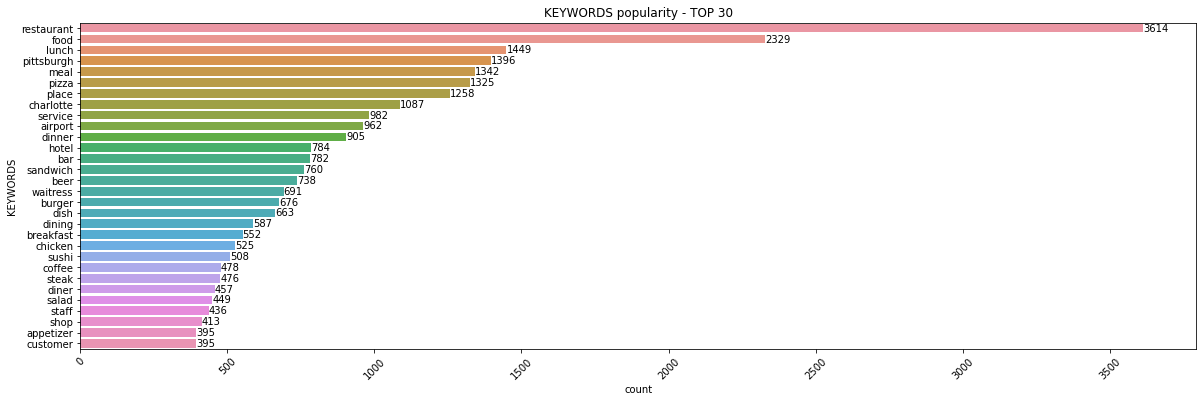

In [167]:
plt.figure(figsize=(20,6))
ax = sns.countplot(y=df.explode("KEYWORDS").KEYWORDS, 
              order=df.explode("KEYWORDS").KEYWORDS.value_counts().index[:30]
              )


ax.bar_label(ax.containers[0])

plt.title("KEYWORDS popularity - TOP 30")
plt.xticks(rotation=45)
plt.show()

In [169]:
df_keywords = df.explode("KEYWORDS")

In [ ]:
df_keywords.head()

user_id               review_id  \
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
0  PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
1  Iu6AxdBYGR4A0wspR9BYHA  KPvLNJ21_4wbYNctrOwWdQ   
1  Iu6AxdBYGR4A0wspR9BYHA  KPvLNJ21_4wbYNctrOwWdQ   

                                                text  votes.cool  \
0  Mr Hoagie is an institution. Walking in, it do...           0   
0  Mr Hoagie is an institution. Walking in, it do...           0   
0  Mr Hoagie is an institution. Walking in, it do...           0   
1  Excellent food. Superb customer service. I mis...           0   
1  Excellent food. Superb customer service. I mis...           0   

              business_id  votes.funny  stars        date    type  \
0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
0  5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
1  5UmKMjUEUNdYWqANhGckJw            0      5  2014-02-13  review   
1  5UmKMjUEUNdYWqANhGckJw            0      5  2014-02-13  review   

   votes.useful   datetime  year  \
0             0 2012-08-01  2012   
0             0 2012-08-01  2012   
0             0 2012-08-01  2012   
1             0 2014-02-13  2014   
1             0 2014-02-13  2014   

                                          text_clean  \
0  mr hoagie institution walk like throwback 30 y...   
0  mr hoagie institution walk like throwback 30 y...   
0  mr hoagie institution walk like throwback 30 y...   
1  excellent food superb customer service miss ma...   
1  excellent food superb customer service miss ma...   

                                                 NER  \
0  [hoagie, 30 year ago old, fashioned menu board...   
0  [hoagie, 30 year ago old, fashioned menu board...   
0  [hoagie, 30 year ago old, fashioned menu board...   
1                                           [superb]   
1                                           [superb]   

                                               NOUNS SENTIMENT star_sentiment  \
0  [year, menu, selection, food, speciality, vote...       POS            POS   
0  [year, menu, selection, food, speciality, vote...       POS            POS   
0  [year, menu, selection, food, speciality, vote...       POS            POS   
1  [food, superb, customer, service, place, tradi...       POS            POS   
1  [food, superb, customer, service, place, tradi...       POS            POS   

  KEYWORDS  
0   subway  
0   hoagie  
0   burger  
1    mario  
1  machine

In [ ]:
# business con reviews con más kw
df_keywords.groupby('business_id').agg({'KEYWORDS':'count'}).sort_values(by="KEYWORDS", ascending=False).reset_index().head(20)

business_id  KEYWORDS
0   3Q0QQPnHcJuX1DLCL9G9Cg      3194
1   mpDxBBGywUE6GRRKja3sBA      1578
2   NeUf9FyCCIN4MEseNyqkXQ      1161
3   jTGQUWGIVvL-aY03C5BEmw       874
4   NTfUFk8GyOLL1uPbEO-pVg       750
5   XmdTkxKyJd7TuDLoiic1kg       747
6   vgXE1I7c9ElcfYyZfQiN1Q       727
7   2X5G4Ujq0s4Wfn4TC7gX0g       726
8   2SwC8wqpZC4B9iFVTgYT9A       717
9   rgmptwPbBH1wLpiBHcbIhA       662
10  2Igiyhi82R8_QaaPplRmCw       639
11  MQnNtW1lHS-eid3QNUoUIw       635
12  CChwRoYVXA3QZulS8a6xOQ       632
13  ePP0Eqz8JKSbtdt2phiB4A       588
14  ym9QwkmB5ZKTyj7q5huTDw       567
15  dxCqGkhtXq-9fYEsX7Mf6Q       563
16  9SPwF-vRgtuHxciFxv5YLA       558
17  WuCcv_Dyd_1B_1-4jwK7sQ       545
18  TxKmAsKQjND5vbhBdUSyIA       539
19  xgK6AAhJ-cYBUCSaLzgTuw       517

In [ ]:
# kw más populares para primer business del item anterior
df_keywords[df_keywords['business_id'] == '3Q0QQPnHcJuX1DLCL9G9Cg'][['business_id','KEYWORDS']].groupby('KEYWORDS').count().sort_values(by="business_id", ascending=False).reset_index().head(20)

KEYWORDS  business_id
0      airport          840
1       flight          180
2      layover           95
3    concourse           94
4    charlotte           83
5   restaurant           62
6          tsa           56
7      airline           54
8      parking           42
9         wifi           39
10         clt           38
11       place           35
12        gate           35
13     airways           35
14     baggage           31
15    restroom           30
16       plane           30
17     shuttle           29
18    bathroom           29
19        food           29

WordCloud para las keywords

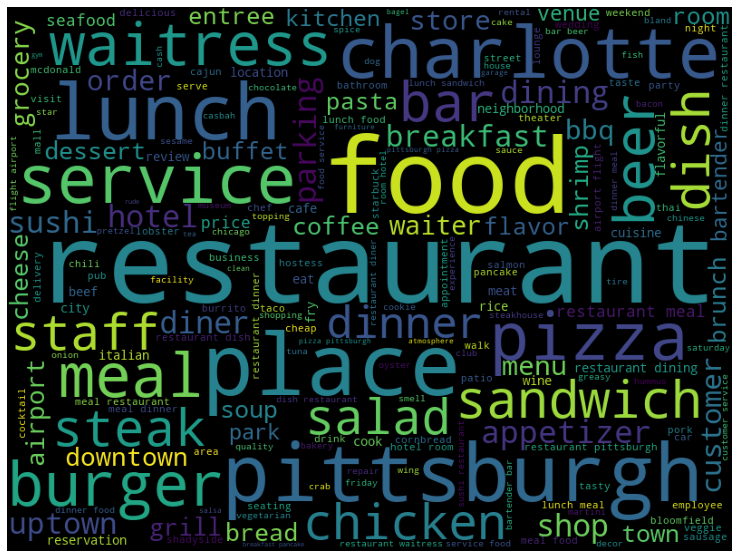

In [170]:
df_keywords['KEYWORDS'] = df_keywords['KEYWORDS'].apply(lambda x : str(x or ""))

cloud(' '.join(df_keywords['KEYWORDS']))

# BERTopic

Ahora utilizaremos BERTopic para extraer tópicos.

In [171]:
topic_model = BERTopic(calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(df["text_clean"].values)

Batches:   0%|          | 0/853 [00:00<?, ?it/s]

2022-12-22 15:30:01,167 - BERTopic - Transformed documents to Embeddings
2022-12-22 15:30:51,248 - BERTopic - Reduced dimensionality
2022-12-22 15:31:38,417 - BERTopic - Clustered reduced embeddings


In [ ]:
topics_data = topic_model.get_topic_info()
topics_data

Topic  Count                                Name
0       -1  10215            -1_food_good_place_order
1        0   1078      0_airport_flight_terminal_gate
2        1    846               1_hotel_room_stay_bed
3        2    741      2_waitress_minute_table_server
4        3    685     3_charlotte_mert_soul_cornbread
..     ...    ...                                 ...
198    197     11          197_maze_map_maize_speaker
199    198     11  198_mac_cheese_crispyness_delirium
200    199     10       199_artic_uso_swirl_everytime
201    200     10             200_beer_sam_ipa_saloon
202    201     10   201_patio_cocktail_wine_avalanche

[203 rows x 3 columns]

El topico -1 corresponde a outliers.

In [ ]:
df["TOPIC_ID"] = topics
df = df.merge(topics_data, left_on="TOPIC_ID", right_on="Topic", how="left")
df = df.rename(columns={"Name": "TOPIC_NAME", "Count": "TOPIC_POPULARITY"})
df = df.drop(["Topic"], axis=1)
df.head(20)

user_id               review_id  \
0   PUFPaY9KxDAcGqfsorJp3Q  Ya85v4eqdd6k9Od8HbQjyA   
1   Iu6AxdBYGR4A0wspR9BYHA  KPvLNJ21_4wbYNctrOwWdQ   
2   auESFwWvW42h6alXgFxAXQ  fFSoGV46Yxuwbr3fHNuZig   
3   uK8tzraOp4M5u3uYrqIBXg  Di3exaUCFNw1V4kSNW5pgA   
4   I_47G-R2_egp7ME5u_ltew  0Lua2-PbqEQMjD9r89-asw   
5   PP_xoMSYlGr2pb67BbqBdA  7N9j5YbBHBW6qguE5DAeyA   
6   JPPhyFE-UE453zA6K0TVgw  mjCJR33jvUNt41iJCxDU_g   
7   2d5HeDvZTDUNVog_WuUpSg  Ieh3kfZ-5J9pLju4JiQDvQ   
8   BShxMIUwaJS378xcrz4Nmg  PU28OoBSHpZLkYGCmNxlmg   
9   fhNxoMwwTipzjO8A9LFe8Q  XsA6AojkWjOHA4FmuAb8XQ   
10  -6rEfobYjMxpUWLNxszaxQ  rkD7UDbQ9VM3Va6bI-eBHQ   
11  KZuaJtFindQM9x2ZoMBxcQ  WExNE-f93SL4D1q8s9QWKg   
12  H9E5VejGEsRhwcbOMFknmQ  iS34GJhMkkt9kCoTJLYEwA   
13  ljwgUJowB69klaR8Au-H7g  S-G0D8Cy7PnqShoBZu8PCA   
14  JbAeIYc89Sk8SWmrBCJs9g  fBQ69-NU9ZyTjjS7Tb5tww   
15  l_szjd-ken3ma6oHDkTYXg  CFiLh7WvH7dM3qVZvNiacQ   
16  zo_soThZw8eVglPbCRNC9A  UzMViMQZuSxOr5wrru3LwQ   
17  4H-IfBDP5GkfNsQeHi4sHA  OEopG9TyhSyyrTk2Uy5SZA   
18  Qs5dcst13DnQJwaBcR4VGg  VXWdUDrVpBAvzaxnHpRUAw   
19  LWbYpcangjBMm4KPxZGOKg  6w6gMZ3iBLGcUM4RBIuifQ   

                                                 text  votes.cool  \
0   Mr Hoagie is an institution. Walking in, it do...           0   
1   Excellent food. Superb customer service. I mis...           0   
2   Yes this place is a little out dated and not o...           0   
3   All the food is great here. But the best thing...           0   
4   We checked this place out this past Monday for...           0   
5   Wing sauce is like water. Pretty much a lot of...           0   
6   Cold cheap beer. Good bar food. Good service. ...           0   
7   I highly recommend this place. The mechanics a...           0   
8   I am a big believer in first impressions, so w...           0   
9   Decent range somewhat close to the city.  The ...           0   
10  Owning a driving range inside the city limits ...           0   
11  This place is absolute garbage...  Half of the...           0   
12  Before I finally made it over to this range I ...           0   
13  I drove by yesterday to get a sneak peak.  It ...           0   
14  THANK YOU ROB! i truly appreciated all the hel...           7   
15  After waiting for almost 30 minutes to trade i...           1   
16  I visited this store several months ago to sim...           0   
17  My fiancé upgraded his phone at the Apple stor...           0   
18  Waited over 45 mins, 2 people ahead of me and ...           1   
19  This place was DELICIOUS!!  My parents saw a r...           0   

               business_id  votes.funny  stars        date    type  \
0   5UmKMjUEUNdYWqANhGckJw            0      4  2012-08-01  review   
1   5UmKMjUEUNdYWqANhGckJw            0      5  2014-02-13  review   
2   5UmKMjUEUNdYWqANhGckJw            0      5  2015-10-31  review   
3   UsFtqoBl7naz8AVUBZMjQQ            0      5  2013-11-08  review   
4   UsFtqoBl7naz8AVUBZMjQQ            0      3  2014-03-29  review   
5   UsFtqoBl7naz8AVUBZMjQQ            0      1  2014-10-29  review   
6   UsFtqoBl7naz8AVUBZMjQQ            0      4  2014-11-28  review   
7   3eu6MEFlq2Dg7bQh8QbdOg            0      5  2014-02-27  review   
8   3eu6MEFlq2Dg7bQh8QbdOg            0      5  2015-06-16  review   
9   cE27W9VPgO88Qxe4ol6y_g            0      3  2012-08-19  review   
10  cE27W9VPgO88Qxe4ol6y_g            0      1  2013-04-18  review   
11  cE27W9VPgO88Qxe4ol6y_g            0      1  2013-07-14  review   
12  cE27W9VPgO88Qxe4ol6y_g            0      4  2013-08-16  review   
13  cE27W9VPgO88Qxe4ol6y_g            0      4  2014-07-11  review   
14  HZdLhv6COCleJMo7nPl-RA            3      5  2013-06-10  review   
15  HZdLhv6COCleJMo7nPl-RA            1      2  2013-12-23  review   
16  HZdLhv6COCleJMo7nPl-RA            0      4  2014-09-04  review   
17  HZdLhv6COCleJMo7nPl-RA            0      1  2015-05-06  review   
18  HZdLhv6COCleJMo7nPl-RA            1      1  2015-11-02  review   
19  mVHrayjG3uZ_RLHkLj-AMg        

In [ ]:
topic_model.visualize_topics()

##### Negocios con más tópicos

In [ ]:
df.groupby('business_id').agg({'TOPIC_ID':'count'}).sort_values(by="TOPIC_ID", ascending=False).reset_index().head(20)

business_id  TOPIC_ID
0   3Q0QQPnHcJuX1DLCL9G9Cg      1068
1   mpDxBBGywUE6GRRKja3sBA       527
2   NeUf9FyCCIN4MEseNyqkXQ       387
3   jTGQUWGIVvL-aY03C5BEmw       292
4   NTfUFk8GyOLL1uPbEO-pVg       250
5   XmdTkxKyJd7TuDLoiic1kg       249
6   vgXE1I7c9ElcfYyZfQiN1Q       243
7   2X5G4Ujq0s4Wfn4TC7gX0g       243
8   2SwC8wqpZC4B9iFVTgYT9A       239
9   rgmptwPbBH1wLpiBHcbIhA       221
10  2Igiyhi82R8_QaaPplRmCw       213
11  MQnNtW1lHS-eid3QNUoUIw       212
12  CChwRoYVXA3QZulS8a6xOQ       211
13  ePP0Eqz8JKSbtdt2phiB4A       197
14  ym9QwkmB5ZKTyj7q5huTDw       189
15  dxCqGkhtXq-9fYEsX7Mf6Q       188
16  9SPwF-vRgtuHxciFxv5YLA       186
17  WuCcv_Dyd_1B_1-4jwK7sQ       182
18  TxKmAsKQjND5vbhBdUSyIA       180
19  xgK6AAhJ-cYBUCSaLzgTuw       173

##### Tópicos del negocio con más tópicos

In [ ]:
df[df['business_id'] == '3Q0QQPnHcJuX1DLCL9G9Cg'][['business_id','TOPIC_NAME']].groupby('TOPIC_NAME').count().sort_values(by="business_id", ascending=False).reset_index().rename(columns = {'business_id':'cantidad'}).head(20)

TOPIC_NAME  cantidad
0       0_airport_flight_terminal_gate       997
1             -1_food_good_place_order        36
2                1_hotel_room_stay_bed         8
3      3_charlotte_mert_soul_cornbread         5
4      5_coffee_starbucks_espresso_tea         4
5     18_german_schnitzel_max_waldhorn         4
6         7_sushi_japanese_roll_korean         2
7              84_closed_close_pm_open         2
8        199_artic_uso_swirl_everytime         1
9           186_key_copy_depot_ulrichs         1
10      39_mexican_salsa_miguel_fajita         1
11  180_comedian_improv_minimum_comedy         1
12        55_rude_store_customer_clerk         1
13      58_rental_car_emerald_national         1
14      14_shrimp_lobster_crab_seafood         1
15        6_chinese_rice_chicken_china         1
16   119_christmas_love_decoration_bob         1
17     33_service_food_excellent_great         1

##### WordCloud de tópicos

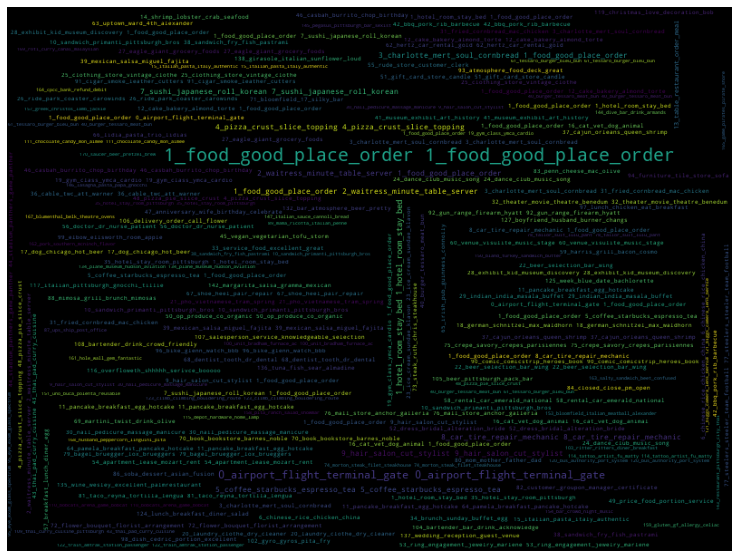

In [ ]:
cloud(' '.join(df['TOPIC_NAME']))

# Modelo para las reviews

In [17]:
def stars_to_sentiments(x):
    """
    Convierte estrella en sentimiento.
    0 = NEG
    1 = NEU 
    2 = POS
    """
    if x <= 2:
        return 0
    elif x == 3:
        return 1
    else:
        return 2

In [18]:
df_copy = df.copy()
df_copy['rating'] = df_copy['stars'].apply(stars_to_sentiments)

AttributeError: ignored

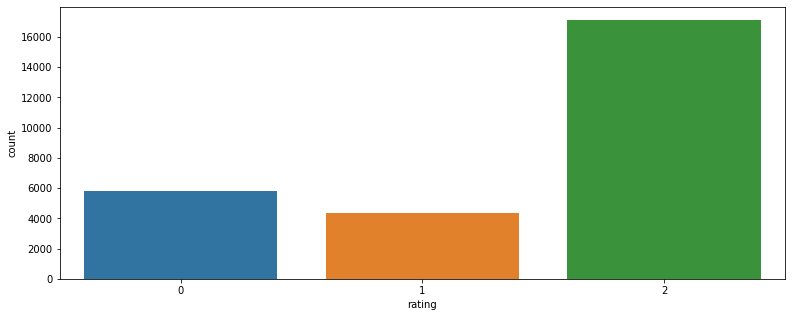

In [97]:
# Graficamos distribución del rating del paso anterior
plt.figure(figsize=(13, 5))
ax = sns.countplot(data=df_copy, x='rating')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('rating')
plt.ylabel('Cantidad')
plt.grid(linewidth=0.3)
plt.title('Distribución del rating', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

Concluimos, a partir del gráfico anterior, que el target está totalmente desbalanceado. Por lo que usaremos el hiperparámetro stratefy al momento de splitear nuestros datos para entrenamiento y evaluación.

In [42]:
X = df_copy['text_clean'].copy()
y = df_copy['rating'].copy()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

In [44]:
print("x_train shape :",X_train.shape)
print("x_test shape  :",X_test.shape)
print("y_train shape :",y_train.shape)
print("y_tets shape  :",y_test.shape)

x_train shape : (21832,)
x_test shape  : (5458,)
y_train shape : (21832,)
y_tets shape  : (5458,)


In [88]:
# Aplicamos CountVectorizer
cv = CountVectorizer()
x_train = cv.fit_transform(X_train)
x_test = cv.transform(X_test)

Logistic Regression

In [89]:
lr = LogisticRegression(max_iter=10000)

lr.fit(x_train,y_train)
y_test_pred_lr = lr.predict(x_test)

score_1 = accuracy_score(y_test,y_test_pred_lr)

In [90]:
print(f"accuracy para el modelo logistic_regression: {score_1*100}")

accuracy para el modelo logistic_regression: 76.34664712348845


In [91]:
cm = confusion_matrix(y_test, y_test_pred_lr)
print("Matriz de Confusión")
print(cm)

Matriz de Confusión
[[ 827  158  173]
 [ 166  266  444]
 [  82  268 3074]]


In [92]:
print(classification_report(y_test, y_test_pred_lr))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74      1158
           1       0.38      0.30      0.34       876
           2       0.83      0.90      0.86      3424

    accuracy                           0.76      5458
   macro avg       0.66      0.64      0.65      5458
weighted avg       0.75      0.76      0.75      5458



In [28]:
# Ponemos a prueba nuestro modelo.
print(lr.predict(cv.transform(['This place is amazing!'])))

[2]


Support Vector Machines

In [81]:
svm = SVC()
svm.fit(x_train,y_train)
y_test_pred_svc = svm.predict(cv.transform(X_test))
score_3 = accuracy_score(y_test,y_test_pred_svc)

In [83]:
print(score_3*100)

76.34664712348845


In [84]:
cm = confusion_matrix(y_test, y_test_pred_svc)
print("Matriz de Confusión")
print(cm)

Matriz de Confusión
[[ 751   33  374]
 [ 137  100  639]
 [  74   34 3316]]


In [86]:
print(classification_report(y_test, y_test_pred_svc))

              precision    recall  f1-score   support

           0       0.78      0.65      0.71      1158
           1       0.60      0.11      0.19       876
           2       0.77      0.97      0.86      3424

    accuracy                           0.76      5458
   macro avg       0.72      0.58      0.59      5458
weighted avg       0.74      0.76      0.72      5458



In [55]:
print(svm.predict(cv.transform(['This place is amazing!'])))

[2]


##### RandomForestClassifier

In [62]:
# report function
def show_metrics(X, y, model, df_model):
    """
    in: X, y, model, df_model
    out: print a best_params_, train_score, test_score, clasification_report and plot the confusion_matrix
    """

    print(f'best_params_: {model.best_params_}')
    train_score = float(df_model.loc[df_model['rank_test_score'] == 1, 'mean_train_score'])
    print(f'Train_score: {train_score}')
    print(f'Test_score_: {model.best_score_}')

    y_test_hat = model.best_estimator_.predict(X)
    clasification_report = classification_report(y, y_test_hat)
    print(clasification_report)

    confusion = confusion_matrix(y, y_test_hat)
    disp = ConfusionMatrixDisplay(confusion)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

best_params_: {'rfc__n_estimators': 132, 'rfc__min_samples_split': 74, 'rfc__min_samples_leaf': 3, 'rfc__max_depth': 34, 'rfc__criterion': 'gini'}
Train_score: 0.8656558947342919
Test_score_: 0.733556173025925
              precision    recall  f1-score   support

           0       0.66      0.74      0.70      1158
           1       0.41      0.36      0.38       876
           2       0.84      0.83      0.84      3424

    accuracy                           0.74      5458
   macro avg       0.64      0.64      0.64      5458
weighted avg       0.73      0.74      0.73      5458



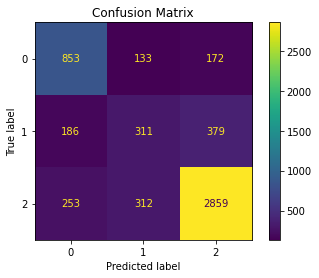

In [63]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_rfc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rfc', RandomForestClassifier(n_jobs=-1, class_weight='balanced',  random_state=42))
])

param_grid = {
            'rfc__criterion': ['entropy', 'gini'],
            'rfc__max_depth': [x for x in range(2, 50, 2)],
            'rfc__min_samples_split': [x for x in range(50, 80, 2)],
            'rfc__min_samples_leaf': [x for x in range(1, 10, 1)],
            'rfc__n_estimators': [x for x in range(100, 150, 2)],
            }

grid_rfc = RandomizedSearchCV(estimator=pipe_rfc,
                                param_distributions=param_grid,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=skf,
                                return_train_score=True,
                                )

grid_rfc.fit(X_train, y_train)

df_rfc = pd.DataFrame(grid_rfc.cv_results_)

# report
show_metrics(X_test, y_test, grid_rfc, df_rfc)

In [67]:
# Probamos el modelo
print(grid_rfc.predict(['I hate this restaurant, the pizza is awful.']))

[0]


In [82]:
print(grid_rfc.predict(['I think that the manager of this restaurant is an excellent person.']))

[0]


# Algunos links usados:
`https://www.kaggle.com/code/shiv1298/sentiment-analysis` <br>
`https://www.kaggle.com/code/sbkshirsagar/nlp-project-review-rating-prediction` <br>
`https://www.kaggle.com/datasets/omkarsabnis/yelp-reviews-dataset/code`